In [ ]:
!pip install langchain langsmith langchain_community langchain_openai langgraph langchain_tavily langchain_unstructured ragatouille unstructured bs4 faiss-cpu rank_llm torch praw amadeus langchain-xai

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of llama-index-core to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of llama-index-core to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of llama-index-indices-managed-llama-cloud to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at mul

In [ ]:
from google.colab import userdata
from langchain import OpenAI
from langchain.prompts import PromptTemplate
import langsmith
from langsmith import traceable
from pydantic import BaseModel, Field, BeforeValidator, model_validator, ConfigDict, computed_field, StringConstraints
from functools import wraps
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_tavily import TavilySearch, TavilyExtract
from typing import List, Dict, Any, Optional, Annotated, Literal, Iterable, Union, Callable
from datetime import date, datetime
from langchain_community.document_loaders import WebBaseLoader
import asyncio
from langchain_unstructured import UnstructuredLoader
from bs4 import SoupStrainer
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
import re
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_core.embeddings import Embeddings
from langchain_community.docstore.in_memory import InMemoryDocstore
import faiss
from langchain_core.tools import tool
from langchain_community.document_compressors.rankllm_rerank import RankLLMRerank
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_core.vectorstores import VectorStoreRetriever, VectorStore
import torch
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import MessagesState
from langchain_core.messages import convert_to_messages
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent
from langchain_core.prompts import PromptTemplate
from langgraph.graph.message import add_messages
import hashlib
from langchain_community.tools.reddit_search.tool import RedditSearchRun, RedditSearchSchema
from langchain_community.utilities.reddit_search import RedditSearchAPIWrapper
from langgraph.graph.message import add_messages
from langchain.agents import AgentExecutor
from langchain_core.messages import ToolMessage, HumanMessage, AIMessage, AnyMessage
import json
from IPython.display import Image, display
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.checkpoint.memory import InMemorySaver
from enum import Enum
import os
import httpx
import json
from langchain_core.tools import Tool
from langgraph.runtime import Runtime
from amadeus import Client, ResponseError
from langchain_xai import ChatXAI
import uuid
import requests
from langgraph.types import interrupt, Command

In [ ]:
TAVILY_API_KEY=userdata.get('tavily')
OPEN_AI_KEY = userdata.get('chatgpt')
LANGSMITH_API_KEY = userdata.get('langsmith')
TRIP_ADVISOR_API = userdata.get('tripadvisor')
RAPID_API = userdata.get('rapid_api')
AMADEUS_API = userdata.get('amedeus')
AMADEUS_SECRET = userdata.get('amadeus_secret')
XAI_API = userdata.get('xai')

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = LANGSMITH_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["OPENAI_API_KEY"] = OPEN_AI_KEY
os.environ["RAPID_API_KEY"] = RAPID_API

In [ ]:
llm = ChatOpenAI(model="gpt-5-mini-2025-08-07", temperature=0, api_key=OPEN_AI_KEY)
llm = ChatXAI(
    model="grok-4-fast-reasoning",
    temperature=0,
    api_key=XAI_API)

# Rag

In [ ]:
# Split
splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=100, separators=[r"\n{2,}",r"\n#{1,6}\s", "\n\n", "\n", " ", "", "!", "?", ".", '\t'])
async def split_docs(docs: List[Document])->List[Document]:
  """Splits documents into chunks"""
  if not docs:
    return []

  splitted_doc = await splitter.atransform_documents(docs)
  return splitted_doc


In [ ]:
#Creating our vectore storage
embedding = OpenAIEmbeddings(api_key=OPEN_AI_KEY, model="text-embedding-3-large", dimensions=1024)
vector_store = FAISS(index=faiss.IndexHNSWFlat(1024, 32, faiss.METRIC_INNER_PRODUCT),
                      docstore=InMemoryDocstore(),
                      embedding_function=embedding,
                      index_to_docstore_id={})
retriever = vector_store.as_retriever(search_kwargs={"k": 20})

In [ ]:
def generate_doc_id(doc: Document) -> str:
  """Generates document's hash"""
  return hashlib.sha256(doc.page_content.encode("utf-8")).hexdigest()

#Adds unique documents to the database
async def add_unique_documents(vector_store: FAISS, docs: List[Document])->List[str]:
  """Creates hash for every document and saves documents to the database"""
  unique_docs = {}

  for doc in docs:
    curr_doc = doc.page_content
    doc_id = generate_doc_id(doc)

    # Check if the document ID already exists in the docstore
    if doc_id not in vector_store.index_to_docstore_id.values():
        unique_docs[curr_doc] = doc_id

  if unique_docs:
    return await vector_store.aadd_texts(list(unique_docs.keys()), ids=list(unique_docs.values()))

  return []

In [ ]:
async def prefilter(query:str, docs: List[Document], k:int=20)->List[Document]:

  if not docs:
    return []

  filtered_docs: VectorStore = await FAISS.afrom_documents(docs, embedding)

  filtered_docs = await filtered_docs.asimilarity_search_with_relevance_scores(query, k=k)
  res = [
      doc for doc, _ in filtered_docs
  ]
  return res if res else None

#Prefilter test

In [ ]:
sample_documents = [
    Document(page_content="This is about machine learning and AI", metadata={"source": "doc1"}),
    Document(page_content="Python programming tutorial for beginners", metadata={"source": "doc2"}),
    Document(page_content="Data science with pandas and numpy", metadata={"source": "doc3"}),
    Document(page_content="Web development using Flask and Django", metadata={"source": "doc4"}),
    Document(page_content="Deep learning neural networks", metadata={"source": "doc5"}),
]

In [ ]:
await prefilter("What is deep learning?", sample_documents)

/tmp/ipython-input-1494782909.py:8: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='e2134b4d-b1f4-4167-b25d-58aafa43bf08', metadata={'source': 'doc5'}, page_content='Deep learning neural networks'), np.float32(0.49374396)), (Document(id='aa7b34b1-d0d3-4f8a-9b2d-d2255ee9af4a', metadata={'source': 'doc1'}, page_content='This is about machine learning and AI'), np.float32(0.2757913)), (Document(id='07832604-b297-4dff-bf41-89807dca285a', metadata={'source': 'doc3'}, page_content='Data science with pandas and numpy'), np.float32(-0.11250651)), (Document(id='fd2c80bd-7368-4d9b-abb2-f61a2bdde180', metadata={'source': 'doc2'}, page_content='Python programming tutorial for beginners'), np.float32(-0.19181895)), (Document(id='3161c4f9-3dc2-4a1c-b6e2-f99b07e3d51b', metadata={'source': 'doc4'}, page_content='Web development using Flask and Django'), np.float32(-0.20944393))]
  filtered_docs = await filtered_docs.asimilarity_search_with_relevance_scores(query, k=k)


[Document(id='e2134b4d-b1f4-4167-b25d-58aafa43bf08', metadata={'source': 'doc5'}, page_content='Deep learning neural networks'),
 Document(id='aa7b34b1-d0d3-4f8a-9b2d-d2255ee9af4a', metadata={'source': 'doc1'}, page_content='This is about machine learning and AI'),
 Document(id='07832604-b297-4dff-bf41-89807dca285a', metadata={'source': 'doc3'}, page_content='Data science with pandas and numpy'),
 Document(id='fd2c80bd-7368-4d9b-abb2-f61a2bdde180', metadata={'source': 'doc2'}, page_content='Python programming tutorial for beginners'),
 Document(id='3161c4f9-3dc2-4a1c-b6e2-f99b07e3d51b', metadata={'source': 'doc4'}, page_content='Web development using Flask and Django')]

# Reranking

In [ ]:
class DefaultInput(BaseModel):
  query: str = Field(description="Questions")

  model_config = ConfigDict(arbitrary_types_allowed=True)

In [ ]:
#Rerank documents
class RerankInput(DefaultInput):
  docs: List[Document]=Field(description="List of documents you want to rerank")
  top_n: Optional[int]=Field(default=10, description="Number of documents to return after reranking")

#Initialize embedding model
model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")

#Reranking documents function
async def rerank(input: RerankInput)->List[Document]:
  """
  Rerank documents using a cross-encoder model.
  Used after the retriever to find the best match.
  Args:
    input: RerankInput
  Returns:
    List[Document]
  """
  if not input.docs:
    return []

  reranker = CrossEncoderReranker(model=model, top_n=input.top_n)

  reranked_docs = await reranker.acompress_documents(input.docs, input.query)

  return reranked_docs

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

# Retrieve

In [ ]:
#Retrieve documents
class RetrieverInput(DefaultInput):
  top_n: Optional[int]=Field(default=10, description="Number of documents to retrieve after reranking")
  k: Optional[int]=Field(default=20, description="Number of documents to return after prefiltering")

#Creating search_db tool
@tool
async def search_db(input: RetrieverInput)-> List[Document]:
  """
  Searches in the database
  Args:
    input: RetrieverInput
  Returns:
    RetrieverOutput
  """

  documents = await retriever.ainvoke(input.query)

  filtered_docs = await prefilter(query=input.query, docs=documents, k=input.k)

  reranked_docs = await rerank(RerankInput(query=input.query, docs=filtered_docs, top_n=input.top_n))
  return reranked_docs

# Reddit search

In [ ]:
#Helper function that normilizes dicts and turns into Document objects
def to_doc(item, *, source: str) -> Document:
    # Normalize anything (dict/row) into a Document
    title = item.get("title", "") if isinstance(item, dict) else ""
    text  = item.get("text") or item.get("selftext") or item.get("body") or ""
    url   = item.get("url") or item.get("permalink") or ""
    page_content = f"{title}\n\n{text}".strip() or title or url
    return Document(page_content=page_content, metadata={"source": source, **(item if isinstance(item, dict) else {})})

In [ ]:
def parse_reddit_results(payload: Any) -> List[Document]:
    """
    Accepts:
      - raw string
      - or {"result": raw_string}
    Returns: List[Document]
    """
    POST_PATTERN = re.compile(
        r"""
        Post\ Title:\s*(?P<title>.*?)\n
        \s*User:\s*(?P<user>.*?)\n
        \s*Subreddit:\s*(?P<subreddit>.*?)\s*:?\s*\n
        \s*Text\ body:\s*(?P<body>.*?)
        \s*Post\ URL:\s*(?P<url>\S+)\n
        \s*Post\ Category:\s*(?P<category>.*?)\.\s*\n
        \s*Score:\s*(?P<score>\d+)
        """,
        re.DOTALL | re.VERBOSE,
    )

    text = payload.get("result") if isinstance(payload, dict) and "result" in payload else payload
    if not isinstance(text, str):
        return []

    docs: List[Document] = []

    for m in POST_PATTERN.finditer(text):
        title = m.group("title").strip().strip("'\"")
        user = m.group("user").strip()
        subreddit = m.group("subreddit").strip()
        body = m.group("body").strip()
        url = m.group("url").strip()
        category = m.group("category").strip()
        score_str = m.group("score").strip()
        try:
            score = int(score_str)
        except ValueError:
            score = None

        # Normalize subreddit (drop trailing colon if present)
        if subreddit.endswith(":"):
            subreddit = subreddit[:-1].strip()

        # Compose page_content (good for rerankers and chunkers)
        page_content = f"{title}\n\n{body}".strip() if (title or body) else url

        page_content = re.sub(r"https?://\S+", "", page_content)
        docs.append(
            Document(
                page_content=page_content,
                metadata={
                    "source": "reddit",
                    "title": title,
                    "url": url,
                    "subreddit": subreddit,
                    "author": user,
                    "category": category,
                    "score": score,
                },
            )
        )
    return docs

In [ ]:
#Search in reddit
class RedditSearchInput(DefaultInput):
  time_filter: Literal["year", "week", "month", "all", "day", "hour"] = Field(description="Time filter for search")
  sort: Literal["relevance" , "hot", "top", "new", "comments"] = Field(description="Sort results by")
  subreddit: Optional[str] = Field(default="all", description="Subreddit to search in")
  limit: Optional[int] = Field(default=20, description="Number of reddit posts to return")
  top_n: Optional[int]=Field(default=10, description="Number of documents to return after reranking")
  k: Optional[int]=Field(default=20, description="Number of documents to return after prefiltering")


user_agent= "langchain_reddit_bot/0.1 by u/CorgiZealousideal407"
client_id = userdata.get('reddit_client_id')
REDDIT_KEY = userdata.get('reddit')

reddit_search = RedditSearchRun(
    api_wrapper=RedditSearchAPIWrapper(
        reddit_client_id=client_id,
        reddit_client_secret=REDDIT_KEY,
        reddit_user_agent=user_agent,
    ),
    description="A tool that searches for the best tourist places and information about them"
)

@tool
async def search_reddit(input: RedditSearchInput)->List[Document]:
  """
  Searches reddit, prefilters and reranks results.
  Search->split->rerank
  Args:
    input: RedditSearchInput
  Returns:
    List[Document]
  Examples:


  """
  #Search in reddit
  search_params = RedditSearchSchema(
    query=input.query,
    sort=input.sort,
    time_filter=input.time_filter,
    subreddit=input.subreddit,
    limit=str(input.limit)
  )

  search_res: str = await reddit_search.arun(search_params.model_dump())

  #Parse the results
  res_doc = parse_reddit_results(search_res)

  #Split documents
  splitted_docs = await split_docs(res_doc)

  #FAISS prefilter
  filtered_docs = await prefilter(query=input.query, docs=splitted_docs, k=input.k)

  #Create tasks
  save_task = add_unique_documents(vector_store=vector_store, docs=filtered_docs)

  rerank_input = RerankInput(query=input.query, docs=filtered_docs, top_n=input.top_n)
  reranked_output_task = rerank(rerank_input)

  #Concurently save unique docs to the db and rerank output
  res = await asyncio.gather(save_task, reranked_output_task)

  return res[1]

#Reddit search test

In [ ]:
results = await search_reddit.ainvoke({
    "input": {
        "query": "restaurants for couples in korea",
        "time_filter": "week",
        "sort": "relevance",
        "limit": 50,
        "top_n": 5,
        "k": 10
    }
})

In [ ]:
results

[Document(id='57f13de2-9a18-4e8f-8cde-d80bff8c2cbc', metadata={'source': 'reddit', 'title': 'Korean Restaurants for Solo Diners near Hongdae (Where Locals Actually Go)', 'url': 'https://www.reddit.com/r/KoreaExperience/comments/1nllawv/korean_restaurants_for_solo_diners_near_hongdae/', 'subreddit': 'r/KoreaExperience', 'author': 'Lopsided_Papaya2485', 'category': 'N/A', 'score': 19}, page_content='---\n\n**[Geunyeoui Bapsang (그녀의밥상)](\n\nIt is a homestyle Korean restaurant in Hongdae specializing in hearty set meals (bapsang). It offers a variety of affordable and satisfying dishes such as stir-fried pork, grilled mackerel, and soybean paste stews, all served with unlimited rice and side dishes. With its casual and welcoming atmosphere, it’s a popular spot for both solo diners and small groups looking for a simple, filling Korean meal.\n\n**Atmosphere**  \n\\#HomestyleKorean, #Affordable, #UnlimitedRefills, #SoloFriendly, #ModerateForeignVisitors'),
 Document(id='820c1458-b566-43f2-86b

# Search the Internet

In [ ]:
#Pages processing
def process_pages(docs: List[Document]) -> List[Document]:
  if not docs:
      return []

  cleaned_docs = []
  for doc in docs:
    if doc.page_content and doc.page_content.strip():
        t = doc.page_content

        # Remove URLs/links
        t = re.sub(r'https?://\S+', '', t)  # Remove http/https URLs
        t = re.sub(r'www\.\S+', '', t)     # Remove www. URLs

        # Existing cleaning
        t = re.sub(r'\n{2,}', '\n\n', t)   # Multiple newlines to double
        t = re.sub(r"[ \t\u00a0]{2,}", " ", t)  # Multiple spaces to single
        t = re.sub(r"\r", "", t)           # Remove carriage returns

        doc.page_content = t.strip()

        # Only keep documents with meaningful content after cleaning
        if len(doc.page_content) > 50:
          cleaned_docs.append(doc)

  return cleaned_docs

In [ ]:
class InternetSearchInput(DefaultInput):
  country: str = Field(description="Country to search in")
  search_depth: Literal["basic", "advanced"] = Field(default="basic", description="Depth of search")
  max_results:Optional[int]=Field(default=5, description="Number of urls to return from the internet search")
  top_n: Optional[int]=Field(default=10, description="Number of documents to return after reranking")
  k: Optional[int]=Field(default=20, description="Number of documents to return after prefiltering")

@tool
async def search_internet(input: InternetSearchInput)->List[Document]:
  """
  Searches for the best places to visit for tourists and information about them.
  Search->split->rerank
  Args:
    input: InternetSearchInput
  Returns:
    InternetSearchOutput
  Examples:
    input:
    search_inp = InternetSearchInput(query="Best places for couple to visit in japan in 2025 september",
                                 country="japan",
                                 search_depth="basic",
                                 max_results=5,
                                 top_n=10
                                 )
    output:
      [Document(id='95c773a6ca295b0549133442a6ae24c582b0e3cf93f5f6e28ffac42893d4498b', metadata={}, page_content='Recommended Activity in SEPTEMBER...
  """
  #Internet search
  tavily_search = TavilySearch(max_results=input.max_results,
                      tavily_api_key=TAVILY_API_KEY,
                      search_depth=input.search_depth,
                      country=input.country)

  tavily_extract = TavilyExtract()


  tavily_results = await tavily_search.ainvoke(input.query)
  urls = [result.get('url') for result in tavily_results.get('results') if result.get('url')]

  if not urls:
    return []

  # Load documents from URLs
  extr_res = await tavily_extract.ainvoke({"urls":urls})

  loaded_docs = []

  for res in extr_res['results']:
    loaded_docs.append(Document(page_content=res.get('raw_content'), metadata={"source": "tavily", "url": res.get('url')}))

  loaded_docs = process_pages(loaded_docs)

  # Split loaded documents
  splitted_docs = await split_docs(loaded_docs)
  #FAISS prefilter
  filtered_docs = await prefilter(query=input.query, docs=splitted_docs, k=input.k)

  if not filtered_docs:
    return []

  #Create tasks
  docs_to_db = add_unique_documents(vector_store=vector_store, docs=filtered_docs)

  rerank_input = RerankInput(query=input.query, docs=filtered_docs, top_n=input.top_n)
  rerank_output = rerank(rerank_input)

  #Concurently save unique docs to the db and rerank output
  res = await asyncio.gather(docs_to_db, rerank_output, return_exceptions=True)
  if res[1]:
    return res[1]

  return []

#Internet search test

In [ ]:
internet_search = await search_internet.ainvoke({
    "input": {
        "query": "Best restaurants for couple to visit in Tokyo in 2025 september",
        "country": "japan",
        "search_depth": "basic",
        "max_results": 3,
        "top_n": 10,
        "k": 20
    }
})

In [ ]:
internet_search

[Document(id='36d9a187-3c97-459e-892c-b0dcb29e4fe9', metadata={'source': 'tavily', 'url': 'https://www.opentable.com/metro/tokyo-restaurants'}, page_content='More info\n\n [Tsuki\n\n ¥¥¥¥\n Price: Very Expensive\n • Japanese\n • Roppongi\n\n •4.5](\n\n### Frequently asked questions\n\nHealthy restaurants located in Tokyo include [神戸牛511]( [Essence]( and [Jinroku in TOKYO](\n\nBottomless brunch in Tokyo is available at [神戸牛511]( [TOSA DINING OKYAKU]( and [銀座焼肉Coco Nemaru Ginza （ここねまるぎんざ）](\n\nThe most romantic restaurant in Tokyo is [FUKUZUSHI -Important! The Menu order is mandatory](\n\n## Explore OpenTable'),
 Document(id='db41b8d2-fa89-4061-8a7a-4ac2571a90c9', metadata={'source': 'tavily', 'url': 'https://www.tripadvisor.com/Restaurants-g298184-Tokyo_Tokyo_Prefecture_Kanto.html'}, page_content='Fine dining\n\n[See all](\n\n[![Image 54](\n\nSponsored\n\n[Kobegyu Sumibiyaki Steak Ginza Fun](\n\n4.7\n\n[(19 reviews)](\n\nSteakhouse • $$$$\n\nOpen now\n\n[Reserve](\n\n[![Image 55](\n\n[S

# Trip advisor tools

In [ ]:
# ----- Common constrained types
NonNegMoney = Annotated[float, Field(ge=0)]  # If you prefer Decimal: Annotated[Decimal, Field(ge=0)]
Lat = Annotated[float, Field(ge=-90, le=90)]
Lon = Annotated[float, Field(ge=-180, le=180)]
Rating = Annotated[float, Field(ge=0, le=5)]
ISO4217 = Annotated[str, Field(pattern=r"^[A-Z]{3}$")]
HttpURLStr = Annotated[str, StringConstraints(
    pattern=r"^https?://[^\s]+$", strip_whitespace=True, min_length=8, max_length=2048
)]
TimeHHMM = Annotated[str, StringConstraints(
    pattern=r"^([01]\d|2[0-3]):[0-5]\d$"
)]

LanguageCode = Literal[
    "ar",
    "zh",
    "zh_TW",
    "da",
    "nl",
    "en_AU",
    "en_CA",
    "en_HK",
    "en_IN",
    "en_IE",
    "en_MY",
    "en_NZ",
    "en_PH",
    "en_SG",
    "en_ZA",
    "en_UK",
    "en",
    "fr",
    "fr_BE",
    "fr_CA",
    "fr_CH",
    "de_AT",
    "de",
    "el",
    "iw",
    "in",
    "it",
    "it_CH",
    "ja",
    "ko",
    "no",
    "pt_PT",
    "pt",
    "ru",
    "es_AR",
    "es_CO",
    "es_MX",
    "es_PE",
    "es",
    "es_VE",
    "es_CL",
    "sv",
    "th",
    "tr",
    "vi"
]

class Address(BaseModel):
  street1: Optional[str] = Field(default=None, description="Street address")
  street2: Optional[str] = Field(default=None, description="Street address")
  city: Optional[str] = Field(default=None, description="City")
  state: Optional[str] = Field(default=None, description="State")
  country: Optional[str] = Field(default=None, description="Country")
  postalcode: Optional[str] = Field(default=None, description="Postal code")
  address_string: Optional[str] = Field(default=None, description="Full address")

  model_config = ConfigDict(extra="forbid")

#Nearby search
class NearbySearch(BaseModel):
  latLong: str=Field(description="Latitude/Longitude pair to scope down the search around a specifc point - eg. '42.3455,-71.10767'")
  category: Optional[Literal["attractions", "restaurants", "geos", "hotels"]]=Field(default=None, description="Filters result set based on property type. ")
  phone: Optional[str]=Field(default=None, description="Phone number to filter the search results by (this can be in any format with spaces and dashes but without the '+' sign at the beginning)")
  address: Optional[str]=Field(default=None, description="Address to filter the search results by")
  radius: Optional[int]=Field(default=None, ge=0, description="Length of the radius from the provided latitude/longitude pair to filter results.")
  radiusUnit: Optional[Literal["km", "mi", "m"]]=Field(default=None, description="Unit for length of the radius. Valid options are 'km', 'mi', 'm' (km=kilometers, mi=miles, m=meters)")
  language: Optional[LanguageCode]=Field(default="en", description="The language in which to return results (e.g. 'en' for English or 'es' for Spanish) from the list of our Supported Languages.")

  model_config = ConfigDict(extra="forbid")

class NearbySearchData(BaseModel):
  location_id: str=Field(description="A unique identifier for a location on Tripadvisor. The location ID can be obtained using the Location Search.")
  name: str
  distance: str
  bearing: str
  address_obj: Address

  model_config = ConfigDict(extra="forbid")

class NearbySearchOutput(BaseModel):
  data: List[NearbySearchData]

#Location search
class SearchLocation(BaseModel):
  searchQuery: str=Field(description="Text to use for searching based on the name of the location")
  latLong: Optional[str]=Field(default=None, description="Latitude/Longitude pair to scope down the search around a specifc point - eg. '42.3455,-71.10767'")
  category: Optional[Literal["attractions", "restaurants", "geos", "hotels"]]=Field(default=None, description="Filters result set based on property type. ")
  phone: Optional[str]=Field(default=None, description="Phone number to filter the search results by (this can be in any format with spaces and dashes but without the '+' sign at the beginning)")
  address: Optional[str]=Field(default=None, description="Address to filter the search results by")
  radius: Optional[int]=Field(default=None, ge=0, description="Length of the radius from the provided latitude/longitude pair to filter results.")
  radiusUnit: Optional[Literal["km", "mi", "m"]]=Field(default=None, description="Unit for length of the radius. Valid options are 'km', 'mi', 'm' (km=kilometers, mi=miles, m=meters)")
  language: Optional[LanguageCode]=Field(default="en", description="The language in which to return results (e.g. 'en' for English or 'es' for Spanish) from the list of our Supported Languages.")

class LocationData(BaseModel):
  location_id: str=Field(description="A unique identifier for a location on Tripadvisor. The location ID can be obtained using the Location Search.")
  name: str
  address_obj: Address

class LocationOutput(BaseModel):
  data: List[LocationData]

  model_config = ConfigDict(extra="forbid")

#Location details
class LocationDetails(BaseModel):
  locationId: str=Field(description="A unique identifier for a location on Tripadvisor. The location ID can be obtained using the Location Search.")
  language: Optional[LanguageCode]=Field(default="en", description="The language in which to return results (e.g. 'en' for English or 'es' for Spanish) from the list of our Supported Languages.")
  currency: Optional[ISO4217]=Field(default="USD", description="The currency code to use for request and response (should follow ISO 4217).")

  model_config = ConfigDict(extra="forbid")

class DetailsOutput(BaseModel):
  location_id: str
  name: str
  description: Optional[str] = None
  web_url: Optional[HttpURLStr] = None
  address_obj: Optional[Address] = None
  latitude: Optional[Lat] = None
  longitude: Optional[Lon] = None
  website: Optional[HttpURLStr] = None
  rating: Optional[Rating] = None
  price_level: Optional[str] = None

  model_config = ConfigDict(extra="forbid")

#Location photos
class LocationPhotos(BaseModel):
  locationId: str=Field(description="A unique identifier for a location on Tripadvisor. The location ID can be obtained using the Location Search.")
  language: Optional[LanguageCode]=Field(default="en", description="The language in which to return results (e.g. 'en' for English or 'es' for Spanish) from the list of our Supported Languages.")
  limit: Optional[int] = Field(default=None, description="The number of results to return")
  offset: Optional[int] = Field(default=None, description="The index of the first result")
  source: Optional[str] = Field(default=None,
                                description="""A comma-separated list of allowed photo sources.
                                Allowed values are 'Expert', 'Management',
                                'Traveler'.If not specified, allow photos from all sources."""
                                )

  model_config = ConfigDict(extra="forbid")


class Image(BaseModel):
  height: Optional[int] = None
  width: Optional[int] = None
  url: Optional[HttpURLStr] = None

class PhotosData(BaseModel):
  id: str
  caption: Optional[str] = Field(default=None, description="The caption of the photo.")
  published_date: Optional[str] = Field(default=None, description="The date when the photo was published.")
  image: Optional[Image] = Field(default=None, description="The URL of the photo.")

  model_config = ConfigDict(extra="forbid")

class PhotosOutput(BaseModel):
  data: List[PhotosData]

  model_config = ConfigDict(extra="forbid")

#Location reviews
class LocationReviews(BaseModel):
  locationId: str=Field(description="A unique identifier for a location on Tripadvisor. The location ID can be obtained using the Location Search.")
  language: Optional[LanguageCode]=Field(default="en", description="The language in which to return results (e.g. 'en' for English or 'es' for Spanish) from the list of our Supported Languages.")
  limit: Optional[int] = Field(default=None, description="The number of results to return")
  offset: Optional[int] = Field(default=None, description="The index of the first result")

  model_config = ConfigDict(extra="forbid")

class ReviewData(BaseModel):
  id: str
  lang: LanguageCode
  location_id: str
  published_date: str
  rating: Optional[Rating]
  url: Optional[HttpURLStr]
  text: Optional[str]
  title: Optional[str] = None
  trip_type: Optional[str] = None
  travel_date: Optional[str] = None

class ReviewOutput(BaseModel):
  data: List[ReviewData]

  model_config = ConfigDict(extra="forbid")


class ComprehensiveLocationInput(BaseModel):
  searchQuery: str=Field(description="Text to use for searching based on the name of the location")
  latLong: Optional[str]=Field(default=None, description="Latitude/Longitude pair to scope down the search around a specifc point - eg. '42.3455,-71.10767'")
  category: Optional[Literal["attractions", "restaurants", "geos", "hotels"]]=Field(default=None, description="Filters result set based on property type. ")
  phone: Optional[str]=Field(default=None, description="Phone number to filter the search results by (this can be in any format with spaces and dashes but without the '+' sign at the beginning)")
  address: Optional[str]=Field(default=None, description="Address to filter the search results by")
  radius: Optional[int]=Field(default=None, ge=0, description="Length of the radius from the provided latitude/longitude pair to filter results.")
  radiusUnit: Optional[Literal["km", "mi", "m"]]=Field(default=None, description="Unit for length of the radius. Valid options are 'km', 'mi', 'm' (km=kilometers, mi=miles, m=meters)")
  language: Optional[LanguageCode]=Field(default="en", description="The language in which to return results (e.g. 'en' for English or 'es' for Spanish) from the list of our Supported Languages.")

  limit_locations: Optional[int] = Field(default=None, description="The number of locations to return")
  photos_limit: Optional[int] = Field(default=None, description="The number of photos to return")
  reviews_limit: Optional[int] = Field(default=None, description="The number of reviews to return")

  currency: Optional[ISO4217] = Field(default="USD", description="The currency code to use for request and response (should follow ISO 4217).")
  offset_photos: Optional[int] = Field(default=None, description="The index of the first photo result")
  offset_reviews: Optional[int] = Field(default=None, description="The index of the first review result")

class ComprehensiveLocationResult(BaseModel):
  """Container for all location data"""
  location_id: str
  name: str
  address: Optional[Address] = None
  details: Optional[DetailsOutput] = None
  photos: Optional[PhotosOutput] = None
  reviews: Optional[ReviewOutput] = None
  error: Optional[str] = None


class TripAdvisor:
  """
  Async client for TripAdvisor Content API v1 (Location endpoints).

  Base URL default: "https://api.content.tripadvisor.com/api/v1"
  All requests add the `key=<API_KEY>` query parameter automatically.

  Parameters
  ----------
  api_key : Optional[str]
      API key for the TripAdvisor Content API. If not provided,
      the client will read the environment variable `TRIP_ADVISOR_API`.
  base_url : Optional[str]
      API base (default "https://api.content.tripadvisor.com/api/v1").
      Should NOT end with a trailing slash.
  """

  def __init__(self, api_key: Optional[str]=None, base_url: Optional[str] = "https://api.content.tripadvisor.com/api/v1"):
    self.api_key = api_key or os.getenv("TRIP_ADVISOR_API")
    if not self.api_key:
      raise RuntimeError("TRIP_ADVISOR_API environment variable not set")

    self._client = httpx.AsyncClient(
            base_url=base_url.rstrip("/"),
            headers={"accept": "application/json"},
            timeout=httpx.Timeout(15.0, connect=10.0),
        )
    self.api_url = base_url + "/location"


  async def aclose(self):
    await self._client.aclose()

  async def __aenter__(self):
      return self

  async def __aexit__(self, exc_type, exc, tb):
      await self._client.aclose()

  async def _aget(self, path: str, params: Dict[str, Any]) -> Dict[str, Any]:
    resp = await self._client.get(path, params=params)
    resp.raise_for_status()
    return resp.json()

  async def search_location(self, input: SearchLocation) -> LocationOutput:
    """
    The Location Search request returns up to 10 locations found by the given search query. Returns up to 10 locations found near the given latitude/longtitude.
    Args:
      input: SearchLocation
    Returns:
      dict
    Output example:
    {
    "data": [
      {
        "location_id": "24035984",
        "name": "Tokyo Restaurant",
        "address_obj": {
          "street1": "13 El Thawra St",
          "street2": "Korba",
          "city": "Cairo",
          "state": "Cairo Governorate",
          "country": "Egypt",
          "postalcode": "4460242",
          "address_string": "13 El Thawra St Korba, Cairo 4460242 Egypt"
        }
      }, ...
    }
    """
    params = {"key": self.api_key, **input.model_dump(exclude_none=True)}

    url = self.api_url + "/search"
    data = await self._aget(url, params)
    data_list = []

    for d in data['data']:
      data_list.append(
          LocationData(
              location_id=d['location_id'],
              name=d['name'],
              address_obj=Address(**d['address_obj']))
      )

    result = LocationOutput(data=data_list)
    return result

  async def location_details(self, input: LocationDetails)->DetailsOutput:
    """
    Returns dictionary of location details.
    Args:
      input: LocationDetails
    Returns:
      dict
    Output example:
    {
    "data": [
      {
        "id": 1006278594,
        "lang": "en",
        "location_id": 3307880,
        "published_date": "2025-05-07T09:58:08Z",
        "rating": 1,
        "helpful_votes": 1,
        "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s1.0-66827-5.svg",
        "url": "https://www.tripadvisor.com/ShowUserReviews-g14134337-d3307880-r1006278594-Reviews-Sky_Restaurant_634_Musashi-Oshiage_Sumida_Tokyo_Tokyo_Prefecture_Kanto.html?m=66827#review1006278594",
        "text": "I had high hopes for Musashi Sky Restaurant in Tokyo, especially given the 10,000 yen deposit, required formal dress code, and menu prices ranging from €135 to €185 per person (with many main courses incurring additional charges). I was expecting a premium fine dining experience comparable to Jules Verne in Paris or Atmosphere in Dubai. Sadly, what I got was one of the most disappointing dining experiences I’ve had at this price point.\n\nFrom the moment we walked in, the ambiance felt cold, minimalist, and uninviting—not at all the elegant or atmospheric setting you’d dress up for. But the real issues started with the food and service.\n\nI had requested a fish main course in advance, as I don’t eat meat. What I was served was a fried, low-grade fish in a basic tomato sauce, with bones still in it. It was not a proper fish dish by any fine dining standard—more like a cafeteria meal than something you’d expect from a high-end restaurant. I couldn’t eat it, and when I politely explained why, the only response was a brief “sorry.” No replacement, no alternative, no effort made.\n\nThe disappointment continued with the non-alcoholic wine pairing. Of the three wines, two were decent, but the third was completely undrinkable. I asked if I could simply switch it for one of the previous wines I had already tasted and liked, but was told that would come at an additional charge. Again, at this level, you expect flexibility and genuine hospitality—not rigid policies and upselling.\n\nIn short, the food was underwhelming, the service was inflexible and dismissive, and the atmosphere was forgettable. Musashi Sky may have a great view, but that’s where the positives end. If you’re looking for a true fine dining experience in Tokyo, I recommend you look elsewhere. This was a costly mistake I won’t repeat—and hope others can avoid.",
        "title": "Hugely Overpriced and Deeply Disappointing",
        "trip_type": "Solo travel",
        "travel_date": "2025-05-31",
        "user": {
          "username": "LiaMoon",
          "user_location": {
            "id": "null"
          },
          "avatar": {
            "thumbnail": "https://media-cdn.tripadvisor.com/media/photo-t/27/b3/8e/c5/caption.jpg",
            "small": "https://media-cdn.tripadvisor.com/media/photo-l/27/b3/8e/c5/caption.jpg",
            "medium": "https://media-cdn.tripadvisor.com/media/photo-f/27/b3/8e/c5/caption.jpg",
            "large": "https://media-cdn.tripadvisor.com/media/photo-s/27/b3/8e/c5/caption.jpg",
            "original": "https://media-cdn.tripadvisor.com/media/photo-m/1280/27/b3/8e/c5/caption.jpg"
          }
        },
        "subratings": {}
      },...
    }
    """
    params = {"key": self.api_key, **input.model_dump(exclude={"locationId"})}

    url = self.api_url + f"/{input.locationId}/details"
    data = await self._aget(url, params)

    result = DetailsOutput(
        location_id=data.get('location_id'),
        name=data.get('name'),
        description=data.get('description'),
        web_url=data.get('web_url'),
        address_obj=data.get('address_obj'),
        latitude=data.get('latitude'),
        longitude=data.get('longitude'),
        website=data.get('website')
    )

    return result

  async def location_photos(self, input: LocationPhotos)->PhotosOutput:
    """
    Returns dictionary of location photos.
    Args:
      input: LocationPhotos
    Returns:
      dict
    Output example:
    {
      "data": [
        {
          "id": 299483021,
          "is_blessed": false,
          "caption": "Main Dining Area",
          "published_date": "2018-01-23T08:29:41.19Z",
          "images": {
            "thumbnail": {
              "height": 50,
              "width": 50,
              "url": "https://media-cdn.tripadvisor.com/media/photo-t/11/d9/bf/8d/main-dining-area.jpg"
            },
            "small": {
              "height": 150,
              "width": 150,
              "url": "https://media-cdn.tripadvisor.com/media/photo-l/11/d9/bf/8d/main-dining-area.jpg"
            },
            "medium": {
              "height": 167,
              "width": 250,
              "url": "https://media-cdn.tripadvisor.com/media/photo-f/11/d9/bf/8d/main-dining-area.jpg"
            },
            "large": {
              "height": 367,
              "width": 550,
              "url": "https://media-cdn.tripadvisor.com/media/photo-s/11/d9/bf/8d/main-dining-area.jpg"
            },
            "original": {
              "height": 1335,
              "width": 2000,
              "url": "https://media-cdn.tripadvisor.com/media/photo-o/11/d9/bf/8d/main-dining-area.jpg"
            }
          },
          "album": "Other",
          "source": {
            "name": "Management",
            "localized_name": "Management"
          },
          "user": {
            "username": "Management"
          }
        },...]
    }
    """
    params = {"key": self.api_key, **input.model_dump(exclude={"locationId"})}

    url = self.api_url + f"/{input.locationId}/photos"
    data = await self._aget(url, params)
    data_list = []
    for d in data['data']:
      original_image = d.get('images').get('original')

      data_list.append(
          PhotosData(
              id=str(d.get('id')),
              caption=d.get('caption'),
              published_date=d.get('published_date'),
              image=Image(height=original_image['height'],
                            width=original_image['height'],
                            url=original_image['url'])
          )
      )
    result = PhotosOutput(data=data_list)
    return result

  async def location_reviews(self, input: LocationReviews)->LocationOutput:
    """
    Returns dictionary of location reviews.
    Args:
      input: LocationReviews
    Returns:
      dict
    Output example:
    {
      "data": [
        {
          "id": 1006278594,
          "lang": "en",
          "location_id": 3307880,
          "published_date": "2025-05-07T09:58:08Z",
          "rating": 1,
          "helpful_votes": 1,
          "rating_image_url": "https://www.tripadvisor.com/img/cdsi/img2/ratings/traveler/s1.0-66827-5.svg",
          "url": "https://www.tripadvisor.com/ShowUserReviews-g14134337-d3307880-r1006278594-Reviews-Sky_Restaurant_634_Musashi-Oshiage_Sumida_Tokyo_Tokyo_Prefecture_Kanto.html?m=66827#review1006278594",
          "text": "I had high hopes for Musashi Sky Restaurant in Tokyo, especially given the 10,000 yen deposit, required formal dress code, and menu prices ranging from €135 to €185 per person (with many main courses incurring additional charges). I was expecting a premium fine dining experience comparable to Jules Verne in Paris or Atmosphere in Dubai. Sadly, what I got was one of the most disappointing dining experiences I’ve had at this price point.\n\nFrom the moment we walked in, the ambiance felt cold, minimalist, and uninviting—not at all the elegant or atmospheric setting you’d dress up for. But the real issues started with the food and service.\n\nI had requested a fish main course in advance, as I don’t eat meat. What I was served was a fried, low-grade fish in a basic tomato sauce, with bones still in it. It was not a proper fish dish by any fine dining standard—more like a cafeteria meal than something you’d expect from a high-end restaurant. I couldn’t eat it, and when I politely explained why, the only response was a brief “sorry.” No replacement, no alternative, no effort made.\n\nThe disappointment continued with the non-alcoholic wine pairing. Of the three wines, two were decent, but the third was completely undrinkable. I asked if I could simply switch it for one of the previous wines I had already tasted and liked, but was told that would come at an additional charge. Again, at this level, you expect flexibility and genuine hospitality—not rigid policies and upselling.\n\nIn short, the food was underwhelming, the service was inflexible and dismissive, and the atmosphere was forgettable. Musashi Sky may have a great view, but that’s where the positives end. If you’re looking for a true fine dining experience in Tokyo, I recommend you look elsewhere. This was a costly mistake I won’t repeat—and hope others can avoid.",
          "title": "Hugely Overpriced and Deeply Disappointing",
          "trip_type": "Solo travel",
          "travel_date": "2025-05-31",
          "user": {
            "username": "LiaMoon",
            "user_location": {
              "id": "null"
            },
            "avatar": {
              "thumbnail": "https://media-cdn.tripadvisor.com/media/photo-t/27/b3/8e/c5/caption.jpg",
              "small": "https://media-cdn.tripadvisor.com/media/photo-l/27/b3/8e/c5/caption.jpg",
              "medium": "https://media-cdn.tripadvisor.com/media/photo-f/27/b3/8e/c5/caption.jpg",
              "large": "https://media-cdn.tripadvisor.com/media/photo-s/27/b3/8e/c5/caption.jpg",
              "original": "https://media-cdn.tripadvisor.com/media/photo-m/1280/27/b3/8e/c5/caption.jpg"
            }
          },
          "subratings": {}
        },...
      ]
    }
    """
    params = {"key": self.api_key, **input.model_dump(exclude={"locationId"})}

    url = self.api_url + f"/{input.locationId}/reviews"
    data = await self._aget(url, params)

    data_list = []

    for d in data['data']:
      data_list.append(
          ReviewData(
              id=str(d.get('id')),
              lang=d.get('lang'),
              location_id=str(d.get('location_id')),
              published_date=d.get('published_date'),
              rating=d.get('rating'),
              url=d.get('url'),
              text=d.get('text'),
              title=d.get('title'),
              trip_type=d.get('trip_type'),
              travel_date=d.get('travel_date')
          )
      )

    result = ReviewOutput(data=data_list)
    return result

  async def nearby_search(self, input: NearbySearch) -> NearbySearchOutput:
    """
    Returns dictionary of nearby search results.
    Args:
      input: NearbySearch
    Returns:
      dict
    Output example:
    {
    "data": [
      {
        "location_id": "258730",
        "name": "Beacon Townhouse Inn 1023",
        "distance": "0.0",
        "bearing": "north",
        "address_obj": {
          "street1": "1023 Beacon St",
          "street2": "",
          "city": "Brookline",
          "state": "Massachusetts",
          "country": "United States",
          "postalcode": "02446-5609",
          "address_string": "1023 Beacon St, Brookline, MA 02446-5609"
        }
      },...]
    }
    """
    params = {"key": self.api_key, **input.model_dump()}

    url = self.api_url + f"/nearby_search"
    data = await self._aget(url, params)

    data_list = []
    for d in data['data']:
      data_list.append(
          LocationData(
              location_id=d.get('location_id'),
              name=d.get('name'),
              distance=d.get('distance'),
              bearing=d.get('bearing'),
              address_obj=Address(**d['address_obj']))
      )
    result = NearbySearchOutput(data=data_list)
    return result


  async def comprehensive_search(
      self,
      input: ComprehensiveLocationInput
  ) -> List[ComprehensiveLocationResult]:
      """
      Performs a comprehensive search that:
      1. Searches for locations based on query
      2. For each location found, fetches details, photos, and reviews concurrently

      Parameters
      ----------
      search_query : str
          Text to search for locations
      lat_long : Optional[str]
          Latitude/Longitude pair (e.g., '42.3455,-71.10767')
      category : Optional[str]
          Filter by type: "attractions", "restaurants", "geos", "hotels"
      phone : Optional[str]
          Filter by phone number
      address : Optional[str]
          Filter by address
      radius : Optional[int]
          Search radius in meters
      radiusUnit : Optional[Literal["km", "mi", "m"]]
          Unit of radius
      limit_locations : int
          Maximum number of locations to fetch full data for (default: 5)
      photos_limit : int
          Number of photos per location (default: 10)
      reviews_limit : int
          Number of reviews per location (default: 10)
      language : Optional[str]
          Language code (default: "en")
      currency : Optional[str]
          Currency code (default: "USD")
      offset_photos : Optional[int]
          Offset for photos (default: None)
      offset_reviews : Optional[int]
          Offset for reviews (default: None)

      Returns
      -------
      List[ComprehensiveLocationResult]
          List of comprehensive results for each location
      """

      # Step 1: Search for locations
      search_input = SearchLocation(
          searchQuery=input.searchQuery,
          latLong=input.latLong,
          category=input.category,
          language=input.language,
          phone=input.phone,
          address=input.address,
          radius=input.radius,
          radiusUnit=input.radiusUnit,
      )

      try:
          search_results = await self.search_location(search_input)
      except Exception as e:
          return []

      if not search_results.data:
          return []

      # Limit the number of locations to process
      locations_to_process = search_results.data[:input.limit_locations]

      # Step 2: For each location, fetch details, photos, and reviews concurrently
      comprehensive_results = []

      async def fetch_all_for_location(location: LocationData) -> ComprehensiveLocationResult:
          """Fetch all data for a single location concurrently"""

          result = ComprehensiveLocationResult(
              location_id=location.location_id,
              name=location.name,
              address=location.address_obj
          )

          # Create input objects for each API call
          details_input = LocationDetails(
              locationId=location.location_id,
              language=input.language,
              currency=input.currency,
          )

          photos_input = LocationPhotos(
              locationId=location.location_id,
              language=input.language,
              limit=input.photos_limit,
              offset=input.offset_photos
          )

          reviews_input = LocationReviews(
              locationId=location.location_id,
              language=input.language,
              limit=input.reviews_limit,
              offset=input.offset_reviews
          )

          # Fetch all data concurrently
          tasks = {
              'details': self.location_details(details_input),
              'photos': self.location_photos(photos_input),
              'reviews': self.location_reviews(reviews_input)
          }

          # Use asyncio.gather with return_exceptions=True to handle partial failures
          results = await asyncio.gather(
              *tasks.values(),
              return_exceptions=True
          )

          # Process results
          for task_name, task_result in zip(tasks.keys(), results):
              if isinstance(task_result, Exception):

                  if result.error:
                      result.error += f"; {task_name} failed"
                  else:
                      result.error = f"{task_name} failed"
              else:
                  if task_name == 'details':
                      result.details = task_result
                  elif task_name == 'photos':
                      result.photos = task_result
                  elif task_name == 'reviews':
                      result.reviews = task_result

          return result

      # Fetch all data for all locations concurrently
      comprehensive_results = await asyncio.gather(
          *[fetch_all_for_location(loc) for loc in locations_to_process],
          return_exceptions=False
      )

      return comprehensive_results





In [ ]:
trip_advisor = TripAdvisor(TRIP_ADVISOR_API)

In [ ]:
#Trip advisor tools creation
#Location search tool
@tool
async def location_search_tool(input: SearchLocation) -> dict:
  """Searches for a location on Tripadvisor based on a query.(returns up to 10 locations found by the given search query.)"""
  return await trip_advisor.search_location(input)

#Location details search
@tool
async def location_details_tool(input: LocationDetails) -> dict:
  """Retrieves details for a specific location on Tripadvisor using its location ID."""
  return await trip_advisor.location_details(input)

#Location photos search
@tool
async def location_photos_tool(input: LocationPhotos) -> dict:
  """Retrieves photos for a specific location on Tripadvisor using its location ID."""
  return await trip_advisor.location_photos(input)

#Location reviews search
@tool
async def location_reviews_tool(input: LocationReviews) -> dict:
  """Retrieves reviews for a specific location on Tripadvisor using its location ID."""
  return await trip_advisor.location_reviews(input)

#Nearby places search
@tool
async def nearby_search_tool(input: NearbySearch) -> dict:
  """Searches for places near a given latitude and longitude on Tripadvisor.(returns up to 10 locations found near the given latitude/longtitude.)"""
  return await trip_advisor.nearby_search(input)

@tool
async def comprehensive_search_tool(input: ComprehensiveLocationInput) -> dict:
  """Searches for places, their reviews, photos, details"""
  return await trip_advisor.comprehensive_search(input)


ta_tools = [location_search_tool, location_details_tool, location_photos_tool, location_reviews_tool, nearby_search_tool]

#TripAdvisor class testing

In [ ]:
compr_res = await trip_advisor.comprehensive_search(ComprehensiveLocationInput(searchQuery="Best hotel for couples in Tokyo, Japan", category='hotels'))

In [ ]:
compr_res

[ComprehensiveLocationResult(location_id='1083549', name='Tobu Hotel Levant Tokyo', address=Address(street1='1-2-2 Kinshi', street2='', city='Sumida', state='Tokyo Prefecture', country='Japan', postalcode='130-0013', address_string='1-2-2 Kinshi, Sumida 130-0013 Tokyo Prefecture'), details=DetailsOutput(location_id='1083549', name='Tobu Hotel Levant Tokyo', description='Trusted Partner of TOKYO SKYTREE(R) TOBU HOTEL LEVANT TOKYO IDEAL LOCATION AND PROXIMITY Being one of the TOKYO SKYTREE® official hotels, our hotel is in the middle of hot tourist area close to TOKYO SKYTREE®, Asakusa, shopping centres along with nice eateries and convenience stores. We are only 300m walk from Kinshicho Station. WONDERFUL VIEW OF TOKYO SKYTREE® We boast our beautiful tower view from some of the rooms and in-house restaurants. Imagine yourself gazing quietly at the sparkling tower at the center of the night sky while resting on your bed or enjoying delicious dinner with your beloved person. It adds up to

In [ ]:
search_res_ta = await trip_advisor.search_location(SearchLocation(searchQuery="Best hotel for couples in Tokyo, Japan", category="hotels", latLong="35.652832,139.839478"))
location_id = str(search_res_ta.data[0].location_id)
review_res_ta = await trip_advisor.location_reviews(LocationReviews(locationId=location_id))
detail_res_ta = await trip_advisor.location_details(LocationDetails(locationId=location_id))
photos_res_ta = await trip_advisor.location_photos(LocationPhotos(locationId=location_id))

In [ ]:
search_res_ta

LocationOutput(data=[LocationData(location_id='20329613', name='Tokyo Bay Shiomi Prince Hotel', address_obj=Address(street1='2-8-16 Shiomi', street2=None, city='Koto', state='Tokyo Prefecture', country='Japan', postalcode='135-0052', address_string='2-8-16 Shiomi, Koto 135-0052 Tokyo Prefecture')), LocationData(location_id='15850522', name='hotel Monday Tokyo Nishikasai', address_obj=Address(street1='6-8-7 Nishikasai', street2=None, city='Edogawa', state='Tokyo Prefecture', country='Japan', postalcode='134-0088', address_string='6-8-7 Nishikasai, Edogawa 134-0088 Tokyo Prefecture')), LocationData(location_id='1567267', name='APA Hotel Resort Tokyo Bay Shiomi', address_obj=Address(street1='2-8-6 Shiomi', street2='', city='Koto', state='Tokyo Prefecture', country='Japan', postalcode='135-0052', address_string='2-8-6 Shiomi, Koto 135-0052 Tokyo Prefecture')), LocationData(location_id='535140', name='Koko Hotel Nishikasai', address_obj=Address(street1='6-17-9 Nishikasai', street2=None, cit

In [ ]:
review_res_ta

ReviewOutput(data=[ReviewData(id='1023014744', lang='en', location_id='20329613', published_date='2025-08-07T00:20:21Z', rating=5.0, url='https://www.tripadvisor.com/ShowUserReviews-g1066449-d20329613-r1023014744-Reviews-Tokyo_Bay_Shiomi_Prince_Hotel-Koto_Tokyo_Tokyo_Prefecture_Kanto.html?m=66827#review1023014744', text='the hotel was super nice and i wish we used the sauna but we’re to busy exploring tokyo . the staff for the most part were super nice and friendly their was one that didn’t seem like she cared but the family mart inside the hotel 24/7 made it super convenient. not to many food options close by compared to other areas but still good options around', title='definitely stay if your going to tokyo disney or tokyo sea will save you time on the train', trip_type='Family', travel_date='2025-07-31'), ReviewData(id='1022664597', lang='en', location_id='20329613', published_date='2025-08-04T22:02:07Z', rating=5.0, url='https://www.tripadvisor.com/ShowUserReviews-g1066449-d203296

In [ ]:
review_res_ta

ReviewOutput(data=[ReviewData(id='1023014744', lang='en', location_id='20329613', published_date='2025-08-07T00:20:21Z', rating=5.0, url='https://www.tripadvisor.com/ShowUserReviews-g1066449-d20329613-r1023014744-Reviews-Tokyo_Bay_Shiomi_Prince_Hotel-Koto_Tokyo_Tokyo_Prefecture_Kanto.html?m=66827#review1023014744', text='the hotel was super nice and i wish we used the sauna but we’re to busy exploring tokyo . the staff for the most part were super nice and friendly their was one that didn’t seem like she cared but the family mart inside the hotel 24/7 made it super convenient. not to many food options close by compared to other areas but still good options around', title='definitely stay if your going to tokyo disney or tokyo sea will save you time on the train', trip_type='Family', travel_date='2025-07-31'), ReviewData(id='1022664597', lang='en', location_id='20329613', published_date='2025-08-04T22:02:07Z', rating=5.0, url='https://www.tripadvisor.com/ShowUserReviews-g1066449-d203296

In [ ]:
detail_res_ta

DetailsOutput(location_id='20329613', name='Tokyo Bay Shiomi Prince Hotel', description=None, web_url='https://www.tripadvisor.com/Hotel_Review-g1066449-d20329613-Reviews-Tokyo_Bay_Shiomi_Prince_Hotel-Koto_Tokyo_Tokyo_Prefecture_Kanto.html?m=66827', address_obj=Address(street1='2-8-16 Shiomi', street2=None, city='Koto', state='Tokyo Prefecture', country='Japan', postalcode='135-0052', address_string='2-8-16 Shiomi, Koto 135-0052 Tokyo Prefecture'), latitude=35.65965, longitude=139.81682, website=None)

In [ ]:
photos_res_ta

PhotosOutput(data=[PhotosData(id='750970341', caption='Superior Twin Room', published_date='2024-07-05T23:41:13.911Z', image=Image(height=853, width=853, url='https://media-cdn.tripadvisor.com/media/photo-m/1280/2c/c2/e5/e5/superior-twin-room.jpg')), PhotosData(id='470422745', caption='ホテルでの女子会にもおすすめ', published_date='2020-09-20T10:19:55.711Z', image=Image(height=854, width=854, url='https://media-cdn.tripadvisor.com/media/photo-m/1280/1c/0a/14/d9/caption.jpg')), PhotosData(id='470211610', caption='ホテルロビー', published_date='2020-09-18T10:06:51.686Z', image=Image(height=853, width=853, url='https://media-cdn.tripadvisor.com/media/photo-m/1280/1c/06/dc/1a/caption.jpg')), PhotosData(id='470422032', caption='フィットネスルーム', published_date='2020-09-20T10:12:04.545Z', image=Image(height=853, width=853, url='https://media-cdn.tripadvisor.com/media/photo-m/1280/1c/0a/12/10/caption.jpg')), PhotosData(id='470421399', caption='正面エントランス', published_date='2020-09-20T10:05:22.128Z', image=Image(height=84

#Amedeus API

In [ ]:
amadeus = Client(client_id=AMADEUS_API, client_secret=AMADEUS_SECRET, hostname='test')

In [ ]:
class FlightSearchInput(BaseModel):
  """Input schema for flight search"""
  originLocationCode: str = Field(..., description="Origin airport/city code (e.g., 'NYC', 'JFK')")
  destinationLocationCode: str = Field(..., description="Destination airport/city code (e.g., 'LAX', 'Los Angeles')")
  departureDate: date = Field(..., description="Departure date in YYYY-MM-DD format")
  returnDate: Optional[date] = Field(None, description="Return date in YYYY-MM-DD format for roundtrip")
  adults: Optional[int] = Field(1, description="Number of adult passengers", ge=1, le=9)
  children: Optional[int] = Field(0, description="Number of children", ge=0, le=9)
  infants: Optional[int] = Field(0, description="Number of infants", ge=0, le=9)
  travelClass: Optional[str] = Field("ECONOMY", description="Travel class: ECONOMY, PREMIUM_ECONOMY, BUSINESS, FIRST")
  maxPrice: Optional[int] = Field(None, description="Maximum price filter")
  currencyCode: Optional[str] = Field("USD", description="Currency code (USD, EUR, etc.)")
  max: Optional[int] = Field(10, description="Maximum number of results", ge=1, le=50)

  model_config = ConfigDict(
    json_encoders={date: lambda v: v.strftime("%Y-%m-%d")}
)


@tool
def search_flights(params: FlightSearchInput)-> Dict[str, Any]:
  """Search for flights using Amadeus API"""
  search_params = params.model_dump(mode='json', exclude_none=True)

  response = amadeus.shopping.flight_offers_search.get(**search_params)
  return response.result



#Amadeus api testing

In [ ]:
params = FlightSearchInput(
    originLocationCode="NYC",
    destinationLocationCode="LAX",
    departureDate=date(2025, 10, 1),
    returnDate=date(2025, 10, 15),
    adults=2,
    max=5
)

In [ ]:
response = search_flights(params)

/tmp/ipython-input-2644490237.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = search_flights(params)


ValidationError: 1 validation error for search_flights
  Input should be a valid dictionary or instance of search_flights [type=model_type, input_value=FlightSearchInput(originL...rrencyCode='USD', max=5), input_type=FlightSearchInput]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type

In [ ]:
response

#Coordinates API

In [ ]:
def get_coordinates_nominatim(location) -> dict:
    """Free geocoding using Nominatim (OpenStreetMap)"""
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        'q': location,
        'format': 'json',
        'limit': 1,
        'addressdetails': 1
    }

    headers = {
        'User-Agent': 'TripPlanner/1.0'
    }

    response = requests.get(base_url, params=params, headers=headers)
    data = response.json()

    if data:
        return str(data[0]['lat'] + "," + data[0]['lon'])
    return None

#Coordinates tool testing

In [ ]:
res = get_coordinates_nominatim("Tokyo, Japan")

In [ ]:
res

'35.6768601,139.7638947'

# Create schemas

In [ ]:
search_tools = [search_db, search_reddit, search_internet]

In [ ]:
#Budget
class BudgetEstimate(BaseModel):
  budget_level: Optional[Literal['$', '$$', '$$$', '$$$$']] = Field(default=None, description="Level of the budget")
  currency: ISO4217 = Field(description="ISO currency code, e.g., KRW, USD, JPY")
  intercity_transport: NonNegMoney = Field(description="Total spend for intercity transport")
  local_transport: NonNegMoney = Field(description="Total spend for local transport")
  food: NonNegMoney = Field(description="Total spend for food & drinks")
  activities: NonNegMoney = Field(description="Total spend for entertainment & activities")
  lodging: NonNegMoney = Field(description="Total spend for lodging")
  other: NonNegMoney = Field(default=0, description="Miscellaneous/reserve buffer")
  budget_per_day: NonNegMoney = Field(description="Total budget per day")
  notes: Optional[str] = Field(default=None, description="Assumptions and brief rationale")

  model_config = ConfigDict(extra="forbid")

  @computed_field
  @property
  def total(self) -> float:
      return float(self.intercity_transport + self.local_transport + self.food + self.activities + self.lodging + self.other)

#Constraints
class CandidateResearch(BaseModel):
  name: Optional[str] = Field(default=None, description="Name")
  description: Optional[str] = Field(default=None, description="Detailed requirements for the candidates")
  candidates_number: Optional[int] = Field(default=None, description="Candidates to return")

class ResearchPlan(BaseModel):
  lodging_candidates: Optional[CandidateResearch] = Field(default=None, description="Min lodging candidates to return")
  activities_candidates: Optional[CandidateResearch] = Field(default=None, description="Min activities candidates to return")
  food_candidates: Optional[CandidateResearch] = Field(default=None, description="Min food candidates to return")
  intercity_transport_candidates: Optional[CandidateResearch] = Field(default=None, description="Min intercity transport candidates to return")
  local_transport_candidates: Optional[CandidateResearch] = Field(default=None, description="Min local transport candidates to return")

  model_config = ConfigDict(extra="forbid")


#Candidates
class CandidateBase(BaseModel):
  id: Optional[str] = Field(default=None, description="Stable identifier if available")
  name: str
  address: Optional[str] = Field(default=None, description="Address")
  price_level: Optional[Literal['$', '$$', '$$$', '$$$$']] = Field(default=None, description="Price level")
  rating: Optional[Rating] = Field(default=None, description="Rating (0-5)")
  reviews: Optional[List[str]] = Field(default=None, description="List of reviews")
  photos: Optional[List[HttpURLStr]] = Field(default=None, description="List of photo URLs")
  url: Optional[HttpURLStr] = Field(default=None, description="Source URL")
  lat: Optional[Lat] = Field(default=None, description="Latitude")
  lon: Optional[Lon] = Field(default=None, description="Longitude")
  evidence_score: Annotated[float, Field(ge=0, le=1)] = 0.0
  source_id: Optional[str] = None
  notes: Optional[str] = Field(default=None, description="Description")

  model_config = ConfigDict(extra="forbid")

#Lodging
class CandidateLodging(CandidateBase):
  area: Optional[str] = Field(default=None, description="Area / neighborhood")
  price_night: Optional[NonNegMoney] = Field(default=None, description="Price per night")
  cancel_policy: Optional[str] = Field(default=None, description="Cancel policy")

class LodgingAgentOutput(BaseModel):
  lodging: List[CandidateLodging] = Field(description="List of lodging options")

  model_config = ConfigDict(extra="forbid")

#Activities
class CandidateActivity(CandidateBase):
  open_time: Optional[TimeHHMM] = Field(default=None, description="Opening time HH:MM local")
  close_time: Optional[TimeHHMM] = Field(default=None, description="Closing time HH:MM local")
  duration_min: Optional[int] = Field(default=None, ge=0, le=12*60, description="Estimated duration in minutes")
  price: Optional[NonNegMoney] = Field(default=None, description="Ticket/entry price")
  tags: List[str] = Field(default_factory=list)

class ActivitiesAgentOutput(BaseModel):
  activities: List[CandidateActivity] = Field(description="List of activities")

  model_config = ConfigDict(extra="forbid")

#Food
class CandidateFood(CandidateBase):
  open_time: Optional[TimeHHMM] = Field(default=None, description="Opening time HH:MM local")
  close_time: Optional[TimeHHMM] = Field(default=None, description="Closing time HH:MM local")
  tags: List[str] = Field(default_factory=list)

class FoodAgentOutput(BaseModel):
  food: List[CandidateFood] = Field(description="List of food options")

  model_config = ConfigDict(extra="forbid")

#Transport
class Transfer(BaseModel):
  name: str = Field(description="Leg name / operator")
  place: str = Field(description="Place of the transfer")
  departure_time: Optional[TimeHHMM] = Field(default=None, description="Departure time HH:MM local")
  arrival_time: Optional[TimeHHMM] = Field(default=None, description="Arrival time HH:MM local")
  duration_min: Optional[int] = Field(default=None, ge=0, le=7*24*60)

  model_config = ConfigDict(extra="forbid")

class CandidateIntercityTransport(BaseModel):
  name: str = Field(description="Route or fare name")
  fare_class: Optional[str] = Field(default=None, description="Fare class")
  refundable: Optional[bool] = None
  url: Optional[HttpURLStr] = Field(default=None, description="Booking URL")
  price: Optional[NonNegMoney] = Field(default=None, description="Total price for the route")
  transfer: List[Transfer] = Field(default_factory=list, description="List of transfers")
  total_duration_min: Optional[int] = Field(default=None, ge=0, le=7*24*60)
  note: Optional[str] = Field(default=None, description="Notes")

  model_config = ConfigDict(extra="forbid")

class IntercityTransportAgentOutput(BaseModel):
  transport: List[CandidateIntercityTransport] = Field(description="List of intercity options")

  model_config = ConfigDict(extra="forbid")

class IntracityHop(BaseModel):
  mode: Literal['walk','bus','subway','taxi','bike','rideshare','tram','ferry']
  from_place: Optional[str] = None
  to_place: Optional[str] = None
  duration_min: Optional[int] = Field(default=None, ge=0, le=24*60)

  model_config = ConfigDict(extra="forbid")

#Recommendations
class RecommendationsOutput(BaseModel):
    # Safety & Security
    safety_level: Literal["very_safe", "safe", "moderate", "risky", "dangerous"] = Field(
        description="Overall safety assessment of the destination based on crime rates, political stability, and tourist safety"
    )
    safety_notes: Optional[List[str]] = Field(
        default_factory=list,
        description="Specific safety concerns, precautions, and tips for travelers (e.g., avoid certain areas, common scams, emergency contacts)"
    )
    travel_advisories: Optional[List[str]] = Field(
        default_factory=list,
        description="Current government travel advisories, warnings, or alerts from relevant authorities"
    )

    # Legal & Documentation
    visa_requirements: Optional[Dict[str, str]] = Field(
        default_factory=dict,
        description="Visa requirements mapped by nationality (e.g., {'US': 'visa_on_arrival', 'EU': 'no_visa_required', 'IN': 'e_visa'})"
    )

    # Cultural & Social
    cultural_considerations: Optional[List[str]] = Field(
        default_factory=list,
        description="Important cultural norms, behaviors, and sensitivities to be aware of to show respect and avoid offense"
    )
    dress_code_recommendations: Optional[List[str]] = Field(
        default_factory=list,
        description="Appropriate clothing guidelines for different contexts (religious sites, restaurants, beaches, business settings)"
    )
    local_customs: Optional[List[str]] = Field(
        default_factory=list,
        description="Traditional practices, social etiquette, greeting customs, and behavioral expectations in local society"
    )
    language_barriers: Optional[List[str]] = Field(
        default_factory=list,
        description="Communication challenges and language-related advice (e.g., 'English widely spoken in hotels', 'Learn basic phrases', 'Translation apps recommended')"
    )

    # Age-Specific Constraints
    child_friendly_rating: int = Field(
        ge=1, le=5,
        description="Rating from 1-5 indicating how suitable the destination is for families with children (1=not recommended, 5=very family-friendly)"
    )
    infant_considerations: Optional[List[str]] = Field(
        default_factory=list,
        description="Special considerations and facilities for traveling with babies (changing facilities, baby food availability, medical care)"
    )
    elderly_accessibility: Optional[List[str]] = Field(
        default_factory=list,
        description="Accessibility features and considerations for elderly travelers (wheelchair access, walking distances, transportation options)"
    )

    # Seasonal & Weather
    weather_conditions: Optional[str] = Field(
        description="Expected weather conditions during the travel period with temperature ranges and precipitation likelihood"
    )
    seasonal_considerations: Optional[List[str]] = Field(
        default_factory=list,
        description="Season-specific factors affecting travel (monsoon seasons, peak tourist times, seasonal closures, festivals)"
    )
    best_time_to_visit: Optional[str] = Field(
        description="Optimal months or seasons to visit based on weather, crowds, and local events"
    )

    # Practical Information
    currency_info: Optional[str] = Field(
        description="Local currency, current exchange rates, and currency exchange recommendations"
    )
    payment_methods: Optional[List[str]] = Field(
        default_factory=list,
        description="Accepted payment methods and their prevalence (cash, credit cards, mobile payments, specific card networks)"
    )

    # Constraints & Limitations
    religious_restrictions: Optional[List[str]] = Field(
        default_factory=list,
        description="Religious or cultural restrictions that may affect travelers (dress codes for religious sites, alcohol availability, dietary limitations)"
    )
    dietary_restrictions_support: Optional[Dict[str, bool]] = Field(
        default_factory=dict,
        description="Availability of support for specific dietary needs (e.g., {'vegetarian': True, 'halal': True, 'gluten_free': False, 'kosher': False})"
    )


#Plan
class PlanForDay(BaseModel):
  day_number: int = Field(ge=1, description="Day number starting at 1")
  day_date: date = Field(description="Date of the day")
  activities: List[CandidateActivity] = Field(default_factory=list, description="Activities for the day")
  food: List[CandidateFood] = Field(default_factory=list, description="Food options for the day")
  intracity_moves: List[IntracityHop] = Field(default_factory=list, description="Within-city moves")
  day_budget: NonNegMoney = Field(description="Budget for the day")

  start_time: Optional[TimeHHMM] = None
  end_time: Optional[TimeHHMM] = None
  notes: Optional[str] = None

  model_config = ConfigDict(extra="forbid")

class FinalPlan(BaseModel):
  days: Optional[List[PlanForDay]] = Field(default=None, description="Per-day plan")
  total_budget: Optional[NonNegMoney] = Field(default=None, description="Total budget for the trip")

  lodging: Optional[CandidateLodging] = Field(default=None, description="Lodging option")
  intercity_transport: Optional[CandidateIntercityTransport] = Field(default=None, description="Intercity transport option")
  currency: Optional[ISO4217] = Field(default=None, description="Currency")
  research_plan: Optional[ResearchPlan] = Field(default=None, description="Research plan if need more information")

  model_config = ConfigDict(extra="forbid")



#Output
class OutputSchema(BaseModel):
  days: List[PlanForDay]
  total_budget: NonNegMoney
  currency: Optional[ISO4217] = "USD"

  model_config = ConfigDict(extra="forbid")


#State
class State(BaseModel):
  messages: Annotated[List[AnyMessage], add_messages]
  destination_coordinates: Optional[str] = Field(default=None, description="Coordinates of the destination")
  estimated_budget: Optional[BudgetEstimate] = Field(default=None, description="Estimated budget for the trip")
  research_plan: Optional[ResearchPlan] = Field(default=None, description="Research plan")
  lodging: Optional[LodgingAgentOutput] = Field(default=None, description="List of lodging options")
  activities: Optional[ActivitiesAgentOutput] = Field(default=None, description="List of activities")
  food: Optional[FoodAgentOutput] = Field(default=None, description="List of food options")
  intercity_transport: Optional[IntercityTransportAgentOutput] = Field(default=None, description="List of intercity options")

  recommendations: Optional[RecommendationsOutput] = Field(default=None, description="List of recommendations")

  final_plan: Optional[FinalPlan] = Field(default=None, description="Final plan")

  model_config = ConfigDict(extra="forbid")

#Context
class Traveller(BaseModel):
  name: str
  date_of_birth: date = Field(description="Date of birth in YYYY-MM-DD format")
  spoken_languages: Optional[List[str]] = Field(default=None, description="List of spoken languages")
  interests: Optional[List[str]] = Field(default=None, description="List of interests")
  nationality: Optional[str] = Field(default=None, description="Nationality")
  notes: Optional[str] = Field(default=None, description="Description")

  model_config = ConfigDict(extra="forbid")

  @computed_field(description="Age group based on date of birth")
  @property
  def age_group(self) -> Literal["infant", "child", "adult"]:
      today = date.today()
      age = today.year - self.date_of_birth.year - (
          (today.month, today.day) < (self.date_of_birth.month, self.date_of_birth.day)
      )

      if age < 2:
          return "infant"
      elif age < 18:
          return "child"
      else:
          return "adult"


class Context(BaseModel):
  travellers: List[Traveller] = Field(default_factory=list)
  budget: NonNegMoney = Field(default=1000)
  currency: ISO4217 = Field(default="USD")

  destination: str
  destination_country: str
  date_from: date
  date_to: date

  group_type: Literal['family', 'couple', 'alone', 'friends', 'business']
  trip_purpose: Optional[str] = Field(default=None, description='Purpose of your trip (vacation, business, romantic)')
  current_location: Optional[str] = None
  notes: Optional[str] = Field(default=None, description="Description")

  model_config = ConfigDict(extra="forbid")

  @model_validator(mode='after')
  def validate_dates(self):
      if self.date_from > self.date_to:
          raise ValueError("date_from must be before or equal to date_to")
      return self

  @computed_field(description="Number of days in the trip (inclusive)")
  @property
  def days_number(self) -> int:
      return (self.date_to - self.date_from).days + 1

  @computed_field(description="Number of adults")
  @property
  def adults_num(self) -> int:
    num = 0
    for traveller in self.travellers:
      if traveller.age_group == 'adult':
        num += 1
    return num

  @computed_field(description="Number of children")
  @property
  def children_num(self) -> int:
    num = 0
    for traveller in self.travellers:
      if traveller.age_group == 'child':
        num += 1
    return num

  @computed_field(description="Number infants")
  @property
  def infant_num(self) -> int:
    num = 0
    for traveller in self.travellers:
      if traveller.age_group == 'infant':
        num += 1
    return num



In [ ]:
ta_tools

[StructuredTool(name='location_search_tool', description='Searches for a location on Tripadvisor based on a query.(returns up to 10 locations found by the given search query.)', args_schema=<class 'langchain_core.utils.pydantic.location_search_tool'>, coroutine=<function location_search_tool at 0x7890343e2fc0>),
 StructuredTool(name='location_details_tool', description='Retrieves details for a specific location on Tripadvisor using its location ID.', args_schema=<class 'langchain_core.utils.pydantic.location_details_tool'>, coroutine=<function location_details_tool at 0x7890343e3740>),
 StructuredTool(name='location_photos_tool', description='Retrieves photos for a specific location on Tripadvisor using its location ID.', args_schema=<class 'langchain_core.utils.pydantic.location_photos_tool'>, coroutine=<function location_photos_tool at 0x7890343e3380>),
 StructuredTool(name='location_reviews_tool', description='Retrieves reviews for a specific location on Tripadvisor using its locati

In [ ]:
#Lodging research agent
lodging_research_agent = create_react_agent(
                                          llm,
                                          tools=[comprehensive_search_tool],
                                          response_format=LodgingAgentOutput,
                                          )

#Activities research agent
activities_research_agent = create_react_agent(llm,
                                          tools=[comprehensive_search_tool],
                                          response_format=ActivitiesAgentOutput,
                                          )
#Restaurants and cafes research agent
food_research_agent = create_react_agent(llm,
                                          tools=[comprehensive_search_tool],
                                          response_format=FoodAgentOutput,
                                          )
#Intercity ransport research agent
intercity_transport_research_agent = create_react_agent(llm,
                                          tools=[search_flights],
                                          response_format=IntercityTransportAgentOutput,
                                          )

#Recommendations research agent
recommendations_research_agent = create_react_agent(llm,
                                          tools=[*search_tools],
                                          response_format=RecommendationsOutput,
                                          )


#Creating nodes

In [ ]:
# Budget estimating node
async def budget_estimate(state: State, runtime: Runtime[Context]) -> dict:
  structured_llm = llm.with_structured_output(BudgetEstimate)

  prompt = f"""Create budget breakdown for {runtime.context.group_type} trip: {runtime.context.current_location} → {runtime.context.destination}, {runtime.context.destination_country}.
  {runtime.context.adults_num} adults, {runtime.context.children_num} children, {runtime.context.infant_num} infants.
  {runtime.context.days_number} days ({runtime.context.date_from} to {runtime.context.date_to}).
  Total budget: {runtime.context.budget} {runtime.context.currency}.
  Trip purpose: {runtime.context.trip_purpose}
  Notes: {runtime.context.notes}"""

  budget = await structured_llm.ainvoke(prompt)
  return {
      "messages": [
          AIMessage(content=f"Estimated budget: {budget.model_dump_json()}", name="budget_estimate")
      ],
      "estimated_budget": budget
  }

# Set research_plan node
async def research_plan(state: State, runtime: Runtime[Context]) -> dict:
  structured_llm = llm.with_structured_output(ResearchPlan)

  prompt = f"""Set candidate counts for travel research based on: {runtime.context}.
  Budget plan: {state.estimated_budget}
  Currency: {runtime.context.currency}.
  Longer trips need more options. Families need more lodging/food. Couples need more activities. Use whole numbers ≥ 0."""

  research_plan = await structured_llm.ainvoke(prompt)

  coordinates = get_coordinates_nominatim(runtime.context.destination + ", " + runtime.context.destination_country)

  return {
      "messages": [
          AIMessage(content=f"Research plan: {research_plan.model_dump_json()}", name="research_plan")
      ],
      "research_plan": research_plan,
      "destination_coordinates": coordinates
  }

async def research_lodging(state: State, runtime: Runtime[Context]):
  prompt = f"""
  You are a travel research assistant specializing in lodging.
  Your task is to select suitable lodging options (hotels, hostels, rentals)
  for the given trip context using only the provided documents.
  Only use facts explicitly present in the documents. Do not invent data.
  Prefer options that fit the group type, trip dates/times, destination area, and lodging budget.

  [INPUT CONTEXT]
  {runtime.context}
  Candidates research details: name - {state.research_plan.lodging_candidates.name}
  {state.research_plan.lodging_candidates.description} (make a query based on description)
  Return only {state.research_plan.lodging_candidates.candidates_number} options

  You have access to the following tools:
  comprehensive_search_tool

  Always use location_search_tool or nearby_search_tool to find places and then
  get this place's details, photos, reviews.
  Try to minimize tool calls. (Count candidate numbers after each call and return only {state.research_plan.lodging_candidates.candidates_number} options.)
  Specify as many parameters as possible to get the best results.
  """

  agent_response = await lodging_research_agent.ainvoke({"messages": [HumanMessage(content=prompt)]})

  # Extract the structured response from the agent
  lodging_output = agent_response.get('structured_response', LodgingAgentOutput(lodging=[]))

  # Extract messages (already a list) - don't wrap in another list!
  messages = agent_response.get('messages', [])

  return {
      "messages": messages,
      "lodging": lodging_output
  }

async def research_activities(state: State, runtime: Runtime[Context]):
    prompt = f"""
    You are a travel research assistant specializing in activities.
    Your task is to select suitable activities (attractions, tours, museums, classes, outdoor experiences, events)
    for the given trip context using only the provided documents.
    Only use facts explicitly present in the documents. Do not invent or infer unavailable data.
    Prefer activities that fit the group type, trip dates/times, destination area, and the activities budget.

    [INPUT CONTEXT]

    {runtime.context}
    Budget (total for activities): {state.estimated_budget.activities} {runtime.context.currency}

    Candidates research details: name - {state.research_plan.activities_candidates.name}
    {state.research_plan.activities_candidates.description} (make a query based on description)
    Return only {state.research_plan.activities_candidates.candidates_number} options

    You have access to the following tools:
    comprehensive_search_tool

    Always use location_search_tool or nearby_search_tool to discover activities and then
    call location_details_tool, location_photos_tool, and location_reviews_tool to enrich each candidate.
    Try to minimize tool calls. (Count candidate numbers after each call and return only {state.research_plan.activities_candidates.candidates_number} options.)
    Specify as many parameters as possible to get the best results.
    """
    agent_response = await activities_research_agent.ainvoke({"messages": [HumanMessage(content=prompt)]})

    # Extract the structured response from the agent
    activities_output = agent_response.get('structured_response', ActivitiesAgentOutput(activities=[]))

    # Extract messages (already a list) - don't wrap in another list!
    messages = agent_response.get('messages', [])

    return {
        "messages": messages,
        "activities": activities_output
    }

async def research_food(state: State, runtime: Runtime[Context]):
    prompt = f"""
    You are a travel research assistant specializing in food & dining.
    Your task is to select suitable eating/drinking options (restaurants, cafes, street food, dessert shops, bars)
    for the given trip context using only the provided documents.
    Use only facts explicitly present in the documents. Do not invent or infer missing data.
    Prefer options that fit the group type, trip dates/hours, destination area, and food budget.

    [INPUT CONTEXT]
    {runtime.context}
    Budget (total for food): {state.estimated_budget.food} {runtime.context.currency}

    Candidates research details: name - {state.research_plan.food_candidates.name}
    {state.research_plan.food_candidates.description} (make a query based on description)
    Return only {state.research_plan.food_candidates.candidates_number} options

    You have access to the following tools:
    comprehensive_search_tool

    Always use location_search_tool or nearby_search_tool to discover places and then
    call location_details_tool, location_photos_tool, and location_reviews_tool to enrich each candidate.
    Try to minimize tool calls. (Count candidate numbers after each call and return only {state.research_plan.food_candidates.candidates_number} options.)
    Specify as many parameters as possible to get the best results.
    """
    agent_response = await food_research_agent.ainvoke({"messages": [HumanMessage(content=prompt)]})

    food_output = agent_response.get('structured_response')
    messages = agent_response.get('messages', [])


    return {
        "messages": messages,
        "food": food_output
    }

async def research_intercity_transport(state: State, runtime: Runtime[Context]):
  prompt = f"""You are a travel research assistant specializing in intercity transport (flights, trains, long-distance buses, ferries).
  Your task is to select suitable options to travel from the origin to the destination for the given trip context, using only the provided documents.
  Use only facts explicitly present in the documents. Do not invent or infer missing data.
  Prefer options that fit the origin/destination, trip dates & time windows, group type & size, baggage needs, and transport budget.

  [INPUT CONTEXT]
  {runtime.context}
  Budget (intercity transport total): {state.estimated_budget.intercity_transport} {runtime.context.currency}

  Candidates research details: name - {state.research_plan.food_candidates.name}
  {state.research_plan.food_candidates.description} (make a query based on description)
  Return only {state.research_plan.food_candidates.candidates_number} options

  Use intercity_transport_search tool to find options.
  """

  agent_response = await intercity_transport_research_agent.ainvoke({"messages": [HumanMessage(content=prompt)]})


  transport_output = agent_response.get('structured_response', IntercityTransportAgentOutput(transport=[]))

  messages = agent_response.get('messages', [])

  return {
      "messages": messages,
      "intercity_transport": transport_output
  }

async def research_recommendations(state: State, runtime: Runtime[Context]):
  prompt = f"""

  You are a professional travel research specialist tasked with conducting comprehensive destination research.
  Your goal is to provide detailed, accurate, and practical recommendations for travelers based on their specific context.
  You can use tools:
  search_db
  search_reddit
  search_internet

  CONTEXT
  {runtime.context}
  """
  agent_response = await recommendations_research_agent.ainvoke({"messages": [HumanMessage(content=prompt)]})

  recommendations_output = agent_response.get('structured_response')

  messages = agent_response.get('messages', [])
  return {
      "messages": messages,
      "recommendations": recommendations_output
  }


async def planner(state: State, runtime: Runtime[Context]):
  schema_info = FinalPlan.model_json_schema()
  prompt = f"""
  You are a Trip Planning Assistant. You MUST always return a valid FinalPlan object.
  You must return data that matches this EXACT schema structure:
  {json.dumps(schema_info, indent=2)}

  Your task:
  - Take the research results provided from other specialized agents
  - Synthesize them into a detailed, day-by-day, coherent, and optimized trip plan
  - Make a research plan only for activities and food(always one lodging and one intercity_transport)

  IMPORTANT: You must return a FinalPlan object with either:
  1. A research_plan field populated (if you need more research)
  2. All other fields populated for the final plan (if research is complete)
  3. Use only given candidates

  Never return None or an empty response.

  [INPUT CONTEXT]
  {state}
  {runtime.context}
  """
  structured_llm = llm.with_structured_output(FinalPlan)

  planner = await structured_llm.ainvoke(prompt)

  if planner.research_plan:
    return {
        "messages": [
            AIMessage(content=f"Research plan: {planner}", name="research_plan")
        ],
        "final_plan": planner
    }

  return {
      "messages": [
          AIMessage(content = f"Final plan: {planner}", name="final_plan")
      ],
      "final_plan": planner,
  }

In [ ]:
from langchain_core.messages import convert_to_messages

def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")
        if 'messages' in node_update:
          messages = convert_to_messages(node_update["messages"])

          if last_message:
            messages = messages[-1:]

            for m in messages:
                pretty_print_message(m, indent=is_subgraph)
            print("\n")

        else:
          print("No messages to display")

In [ ]:
context = Context(
    travellers=[
        Traveller(name="John", date_of_birth=date(1990, 1, 1)),
        Traveller(name="Jane", date_of_birth=date(1985, 5, 15)),
    ],

    budget=3000,
    currency="USD",
    destination="Tokyo",
    destination_country="Japan",
    date_from=date(2025, 10, 1),
    date_to=date(2025, 10, 8),
    group_type="couple",
    current_location="Seoul",
)
state = State(messages=[])
runtime = Runtime(context=context)

#Budget estimate testing

In [ ]:
#Budget node test
budget_est = await budget_estimate(state, runtime)
budget_est

{'messages': [AIMessage(content='Estimated budget: {"budget_level":"$$","currency":"USD","intercity_transport":600.0,"local_transport":160.0,"food":480.0,"activities":400.0,"lodging":700.0,"other":660.0,"budget_per_day":375.0,"notes":"Budget breakdown for 2 adults on an 8-day trip from Seoul to Tokyo. Includes round-trip flights, moderate lodging, food, local transport, activities, and buffer. Total: 3000 USD.","total":3000.0}', additional_kwargs={}, response_metadata={}, name='budget_estimate')],
 'estimated_budget': BudgetEstimate(budget_level='$$', currency='USD', intercity_transport=600.0, local_transport=160.0, food=480.0, activities=400.0, lodging=700.0, other=660.0, budget_per_day=375.0, notes='Budget breakdown for 2 adults on an 8-day trip from Seoul to Tokyo. Includes round-trip flights, moderate lodging, food, local transport, activities, and buffer. Total: 3000 USD.', total=3000.0)}

In [ ]:
bdgt = budget_est['estimated_budget']
bdgt

BudgetEstimate(budget_level='$$', currency='USD', intercity_transport=600.0, local_transport=160.0, food=480.0, activities=400.0, lodging=700.0, other=660.0, budget_per_day=375.0, notes='Budget breakdown for 2 adults on an 8-day trip from Seoul to Tokyo. Includes round-trip flights, moderate lodging, food, local transport, activities, and buffer. Total: 3000 USD.', total=3000.0)

In [ ]:
state.estimated_budget = bdgt
state

State(messages=[], destination_coordinates=None, estimated_budget=BudgetEstimate(budget_level='$$', currency='USD', intercity_transport=600.0, local_transport=160.0, food=480.0, activities=400.0, lodging=700.0, other=660.0, budget_per_day=375.0, notes='Budget breakdown for 2 adults on an 8-day trip from Seoul to Tokyo. Includes round-trip flights, moderate lodging, food, local transport, activities, and buffer. Total: 3000 USD.', total=3000.0), research_plan=None, lodging=None, activities=None, food=None, intercity_transport=None, recommendations=None, final_plan=None)

#Research plan testing

In [ ]:
research_plan_test = await research_plan(state, runtime)
research_plan_test

{'messages': [AIMessage(content='Research plan: {"lodging_candidates":{"name":null,"description":null,"candidates_number":6},"activities_candidates":{"name":null,"description":null,"candidates_number":10},"food_candidates":{"name":null,"description":null,"candidates_number":6},"intercity_transport_candidates":{"name":null,"description":null,"candidates_number":4},"local_transport_candidates":{"name":null,"description":null,"candidates_number":4}}', additional_kwargs={}, response_metadata={}, name='research_plan')],
 'research_plan': ResearchPlan(lodging_candidates=CandidateResearch(name=None, description=None, candidates_number=6), activities_candidates=CandidateResearch(name=None, description=None, candidates_number=10), food_candidates=CandidateResearch(name=None, description=None, candidates_number=6), intercity_transport_candidates=CandidateResearch(name=None, description=None, candidates_number=4), local_transport_candidates=CandidateResearch(name=None, description=None, candidate

In [ ]:
state.research_plan = research_plan_test['research_plan']
state.destination_coordinates = research_plan_test['destination_coordinates']
state

State(messages=[], destination_coordinates='35.6768601,139.7638947', estimated_budget=BudgetEstimate(budget_level='$$', currency='USD', intercity_transport=600.0, local_transport=160.0, food=480.0, activities=400.0, lodging=700.0, other=660.0, budget_per_day=375.0, notes='Budget breakdown for 2 adults on an 8-day trip from Seoul to Tokyo. Includes round-trip flights, moderate lodging, food, local transport, activities, and buffer. Total: 3000 USD.', total=3000.0), research_plan=ResearchPlan(lodging_candidates=CandidateResearch(name=None, description=None, candidates_number=6), activities_candidates=CandidateResearch(name=None, description=None, candidates_number=10), food_candidates=CandidateResearch(name=None, description=None, candidates_number=6), intercity_transport_candidates=CandidateResearch(name=None, description=None, candidates_number=4), local_transport_candidates=CandidateResearch(name=None, description=None, candidates_number=4)), lodging=None, activities=None, food=None, 

#Research lodging node testing

In [ ]:
#Lodging node
lodging_research = await research_lodging(state, runtime)
lodging_research

{'messages': [HumanMessage(content="\n  You are a travel research assistant specializing in lodging.\n  Your task is to select suitable lodging options (hotels, hostels, rentals)\n  for the given trip context using only the provided documents.\n  Only use facts explicitly present in the documents. Do not invent data.\n  Prefer options that fit the group type, trip dates/times, destination area, and lodging budget.\n\n  [INPUT CONTEXT]\n  travellers=[Traveller(name='John', date_of_birth=datetime.date(1990, 1, 1), spoken_languages=None, interests=None, nationality=None, notes=None, age_group='adult'), Traveller(name='Jane', date_of_birth=datetime.date(1985, 5, 15), spoken_languages=None, interests=None, nationality=None, notes=None, age_group='adult')] budget=3000.0 currency='USD' destination='Tokyo' destination_country='Japan' date_from=datetime.date(2025, 10, 1) date_to=datetime.date(2025, 10, 8) group_type='couple' trip_purpose=None current_location='Seoul' notes=None days_number=8 ad

#Activities research testing

In [ ]:
activities_research = await research_activities(state, runtime)
activities_research

CancelledError: 

In [ ]:
activities_research['messages']

In [ ]:
activities_research['activities']['structured_response'].model_dump()

#Food research test

In [ ]:
food_research = await research_food(state, runtime)
food_research

In [ ]:
food_research['food']['structured_response'].model_dump()

#Intercity transport research test

In [ ]:
intercity_transport_research = await research_intercity_transport(state, runtime)
intercity_transport_research

In [ ]:
intercity_transport_research['intercity_transport']['structured_response'].model_dump()

{'transport': [{'name': 'Seoul to Tokyo Direct Flight',
   'fare_class': 'Economy',
   'refundable': True,
   'url': 'https://example-airline.com/seoul-tokyo',
   'price': 750.0,
   'transfer': [{'name': 'Example Airline',
     'place': 'Incheon International Airport',
     'departure_time': '10:00',
     'arrival_time': '12:30',
     'duration_min': 150}],
   'total_duration_min': 150,
   'note': 'Direct flight with baggage included.'},
  {'name': 'Seoul to Tokyo via Busan',
   'fare_class': 'Economy',
   'refundable': False,
   'url': 'https://example-ferry.com/seoul-busan-tokyo',
   'price': 600.0,
   'transfer': [{'name': 'KTX Train',
     'place': 'Seoul Station',
     'departure_time': '08:00',
     'arrival_time': '10:30',
     'duration_min': 150},
    {'name': 'Ferry Service',
     'place': 'Busan Port',
     'departure_time': '12:00',
     'arrival_time': '18:00',
     'duration_min': 360}],
   'total_duration_min': 510,
   'note': 'Includes train and ferry transfer. Baggage 

#Recommendations research test

In [ ]:
reccomendations_research = await research_recommendations(state, runtime)
reccomendations_research

Fetching pages: 100%|##########| 5/5 [00:07<00:00,  1.41s/it]


{'messages': [HumanMessage(content="\n\n  You are a professional travel research specialist tasked with conducting comprehensive destination research.\n  Your goal is to provide detailed, accurate, and practical recommendations for travelers based on their specific context.\n  You can use tools:\n  search_db\n  search_reddit\n  search_internet\n\n  CONTEXT\n  travellers=[Traveller(name='John', date_of_birth=datetime.date(1990, 1, 1), spoken_languages=None, interests=None, nationality=None, notes=None, age_group='adult'), Traveller(name='Jane', date_of_birth=datetime.date(1985, 5, 15), spoken_languages=None, interests=None, nationality=None, notes=None, age_group='adult')] budget=3000.0 currency='USD' destination='Tokyo' destination_country='Japan' date_from=datetime.date(2025, 10, 1) date_to=datetime.date(2025, 10, 8) group_type='couple' trip_purpose=None current_location='Seoul' notes=None days_number=8 adults_num=2 children_num=0 infant_num=0\n  ", additional_kwargs={}, response_meta

In [ ]:
reccomendations_research['recommendations']

RecommendationsOutput(safety_level='very_safe', safety_notes=['Tokyo is one of the safest cities globally with low violent crime rates. Petty theft is rare but watch belongings in crowded areas like Shibuya. Political stability is high. For couples, avoid isolated areas at night and use reputable taxis. Emergency: Dial 110 for police, 119 for medical. Download the Safety Tips app from JNTO.'], travel_advisories=['No major advisories from US State Dept or equivalent as of 2025; Japan is Level 1 (exercise normal precautions). Monitor for natural disasters like typhoons, though October is low-risk.'], visa_requirements={'KR': 'no_visa_required'}, cultural_considerations=['Respect personal space and avoid loud behavior in public. Bow slightly when greeting. Tipping is not customary and can offend. Be punctual for reservations. For couples, public displays of affection are subtle—hand-holding is fine, but kissing is rare in public.'], dress_code_recommendations=['Casual comfortable clothing

#Planner testing

In [ ]:
planner_state = State(
        messages=[
            HumanMessage(content="Plan a trip to Paris"),
            AIMessage(content="I'll help you plan your trip to Paris")
        ],
        destination_coordinates="48.8566,2.3522",
        estimated_budget=BudgetEstimate(
            budget_level="$$",
            currency="USD",
            intercity_transport=500,
            local_transport=200,
            food=600,
            activities=400,
            lodging=800,
            other=100,
            budget_per_day=520,
            notes="Mid-range budget for couple"
        ),
        lodging=LodgingAgentOutput(
            lodging=[
                CandidateLodging(
                    name="Hotel Le Marais",
                    address="123 Rue de Rivoli, Paris",
                    price_level="$$",
                    rating=4.5,
                    price_night=160,
                    area="Le Marais",
                    cancel_policy="Free cancellation up to 24 hours"
                ),
                CandidateLodging(
                    name="Boutique Hotel Saint-Germain",
                    address="45 Boulevard Saint-Germain, Paris",
                    price_level="$$$",
                    rating=4.7,
                    price_night=220,
                    area="Saint-Germain-des-Prés"
                )
            ]
        ),
        activities=ActivitiesAgentOutput(
            activities=[
                CandidateActivity(
                    name="Eiffel Tower",
                    address="Champ de Mars, Paris",
                    price_level="$$",
                    rating=4.8,
                    open_time="09:30",
                    close_time="23:00",
                    duration_min=120,
                    price=28,
                    tags=["landmark", "views", "must-see"]
                ),
                CandidateActivity(
                    name="Louvre Museum",
                    address="Rue de Rivoli, Paris",
                    price_level="$$",
                    rating=4.7,
                    open_time="09:00",
                    close_time="18:00",
                    duration_min=240,
                    price=17,
                    tags=["museum", "art", "history"]
                )
            ]
        ),
        food=FoodAgentOutput(
            food=[
                CandidateFood(
                    name="L'Ami Jean",
                    address="27 Rue Malar, Paris",
                    price_level="$$",
                    rating=4.6,
                    open_time="12:00",
                    close_time="14:00",
                    tags=["bistro", "french", "local"]
                ),
                CandidateFood(
                    name="Breizh Café",
                    address="109 Rue Vieille du Temple, Paris",
                    price_level="$",
                    rating=4.5,
                    open_time="11:30",
                    close_time="22:00",
                    tags=["casual", "crepes", "modern"]
                )
            ]
        ),
        intercity_transport=IntercityTransportAgentOutput(
            transport=[
                CandidateIntercityTransport(
                    name="Flight NYC-Paris",
                    fare_class="Economy",
                    refundable=False,
                    price=450,
                    transfer=[
                        Transfer(
                            name="Direct Flight",
                            place="JFK to CDG",
                            departure_time="21:00",
                            arrival_time="10:00",
                            duration_min=420
                        )
                    ],
                    total_duration_min=420
                )
            ]
        ),
        recommendations=RecommendationsOutput(
            # Required fields
            safety_level="safe",
            child_friendly_rating=4,

            # Optional fields that might be causing issues - ensure they have default values
            safety_notes=["Keep valuables secure in tourist areas"],
            travel_advisories=[],
            visa_requirements={"US": "no_visa_required"},
            cultural_considerations=["Greet with 'Bonjour' when entering shops"],
            dress_code_recommendations=["Smart casual for restaurants"],
            local_customs=["Tipping is not mandatory but appreciated"],
            language_barriers=["English widely spoken in tourist areas"],
            infant_considerations=[],
            elderly_accessibility=["Most major attractions have wheelchair access"],
            weather_conditions="Mild, 15-22°C, occasional rain",
            seasonal_considerations=["June is peak tourist season"],
            best_time_to_visit="April-May or September-October for fewer crowds",  # ADDED THIS
            currency_info="EUR - Euro, 1 USD = 0.92 EUR",
            payment_methods=["Credit cards widely accepted", "Some places cash only"],
            religious_restrictions=[],
            dietary_restrictions_support={"vegetarian": True, "vegan": True, "gluten_free": True}
        )
    )
planner_context = Context(
    travellers=[
        Traveller(
            name="John Doe",
            date_of_birth=date(1990, 1, 1),
            spoken_languages=["English", "Spanish"],
            interests=["history", "food"],
            nationality="US"
        ),
        Traveller(
            name="Jane Doe",
            date_of_birth=date(1992, 6, 15),
            spoken_languages=["English"],
            interests=["art", "shopping"],
            nationality="US"
        )
    ],
    budget=3000,
    currency="USD",
    destination="Paris",
    destination_country="France",
    date_from=date(2024, 6, 1),
    date_to=date(2024, 6, 2),
    group_type="couple",
    trip_purpose="vacation",
    current_location="New York",
    notes="Anniversary trip"
)

In [ ]:
planner_res = await planner(planner_state, Runtime(context=planner_context))
planner_res

{'messages': [AIMessage(content='Final plan: days=[PlanForDay(day_number=1, day_date=datetime.date(2024, 6, 1), activities=[CandidateActivity(id=None, name=\'Eiffel Tower\', address=\'Champ de Mars, Paris\', price_level=\'$$\', rating=4.8, reviews=None, photos=None, url=None, lat=None, lon=None, evidence_score=0.0, source_id=None, notes=\'Iconic landmark visit for anniversary\', open_time=\'09:30\', close_time=\'23:00\', duration_min=120, price=28.0, tags=[\'landmark\', \'views\', \'must-see\'])], food=[CandidateFood(id=None, name=\'Breizh Café\', address=\'109 Rue Vieille du Temple, Paris\', price_level=\'$\', rating=4.5, reviews=None, photos=None, url=None, lat=None, lon=None, evidence_score=0.0, source_id=None, notes=\'Casual crepes for lunch\', open_time=\'11:30\', close_time=\'22:00\', tags=[\'casual\', \'crepes\', \'modern\']), CandidateFood(id=None, name="L\'Ami Jean", address=\'27 Rue Malar, Paris\', price_level=\'$$\', rating=4.6, reviews=None, photos=None, url=None, lat=None,

In [ ]:
planner_res['final_plan']

FinalPlan(days=[PlanForDay(day_number=1, day_date=datetime.date(2024, 6, 1), activities=[CandidateActivity(id=None, name='Eiffel Tower', address='Champ de Mars, Paris', price_level='$$', rating=4.8, reviews=None, photos=None, url=None, lat=None, lon=None, evidence_score=0.0, source_id=None, notes='Iconic landmark visit for anniversary', open_time='09:30', close_time='23:00', duration_min=120, price=28.0, tags=['landmark', 'views', 'must-see'])], food=[CandidateFood(id=None, name='Breizh Café', address='109 Rue Vieille du Temple, Paris', price_level='$', rating=4.5, reviews=None, photos=None, url=None, lat=None, lon=None, evidence_score=0.0, source_id=None, notes='Casual crepes for lunch', open_time='11:30', close_time='22:00', tags=['casual', 'crepes', 'modern']), CandidateFood(id=None, name="L'Ami Jean", address='27 Rue Malar, Paris', price_level='$$', rating=4.6, reviews=None, photos=None, url=None, lat=None, lon=None, evidence_score=0.0, source_id=None, notes='Bistro dinner', open_t

#Creating helper nodes


In [ ]:
#Route node for planner
async def route_from_planner(state: State, runtime: Runtime[Context]) -> Union[str, List[str]]:
  """Returns a list of nodes to execute in parallel based on conditions"""
  nodes_to_execute = []

  # Check if final_plan and research_plan exist
  if not state.final_plan or not state.final_plan.research_plan:
      return END

  research_plan = state.final_plan.research_plan

  # Direct attribute access (works if these are Optional[bool] fields)
  if research_plan.activities_candidates:
      nodes_to_execute.append("research_activities")

  if research_plan.food_candidates:
      nodes_to_execute.append("research_food")

  if research_plan.recommendations:
      nodes_to_execute.append("research_recommendations")

  return nodes_to_execute if nodes_to_execute else END

In [ ]:
async def combined_human_review(state: State, runtime: Runtime[Context]) -> Dict[str, Any]:
    """Single node that handles both lodging and transport selection"""

    interrupts_needed = []

    if state.lodging and state.lodging.lodging:
        interrupts_needed.append({
            "type": "lodging",
            "task": "Choose lodging option",
            "options": [lodging.model_dump() for lodging in state.lodging.lodging]
        })

    if state.intercity_transport and state.intercity_transport.transport:
        interrupts_needed.append({
            "type": "intercity_transport",
            "task": "Choose intercity_transport option",
            "options": [transport.model_dump() for transport in state.intercity_transport.transport]
        })

    if not interrupts_needed:
        return {}

    # Import interrupt RIGHT BEFORE using it to avoid namespace conflicts
    from langgraph.types import interrupt

    # This will either:
    # 1. Pause execution on first run (and store interrupt data)
    # 2. Return the resume data when resumed
    result = interrupt({
        "task": "Make your selections for the following options",
        "selections": interrupts_needed
    })

    # This code runs AFTER resume
    # 'result' now contains your resume_data_HITL
    response = {}

    if "lodging" in result:
        selected_lodging = CandidateLodging(**result["lodging"])
        response["lodging"] = LodgingAgentOutput(lodging=[selected_lodging])

    if "intercity_transport" in result:
        selected_transport = CandidateIntercityTransport(**result["intercity_transport"])
        response["intercity_transport"] = IntercityTransportAgentOutput(transport=[selected_transport])

    return response

#Human in the loop test

In [ ]:
builder = StateGraph(State, context=Context)
builder.add_node("node", combined_human_review)

builder.add_edge(START, "node")
builder.add_edge("node", END)

checkpointer_HITL = InMemorySaver()
compiled_grph = builder.compile(checkpointer=checkpointer_HITL)

NameError: name 'combined_human_review' is not defined

In [ ]:
HITL_test_state = State(
        messages=[
            HumanMessage(content="Plan a trip to Paris"),
            AIMessage(content="I'll help you plan your trip to Paris")
        ],
        lodging=LodgingAgentOutput(
            lodging=[
                CandidateLodging(
                    name="Hotel Le Marais",
                    address="123 Rue de Rivoli, Paris",
                    price_level="$$",
                    rating=4.5,
                    price_night=160,
                    area="Le Marais",
                    cancel_policy="Free cancellation up to 24 hours"
                    )]
                ),
          intercity_transport=IntercityTransportAgentOutput(
              transport=[
                  CandidateIntercityTransport(
                      name="Flight NYC-Paris",
                      fare_class="Economy",
                      refundable=False,
                      price=450,
                      transfer=[
                          Transfer(
                              name="Direct Flight",
                              place="JFK to CDG",
                              departure_time="21:00",
                              arrival_time="10:00",
                              duration_min=420
                          )
                      ],
                      total_duration_min=420
                  )
              ]
          )
        )

In [ ]:
HITL_config = {
    "recursion_limit": 100,
    "configurable":{"thread_id": '3'}
}

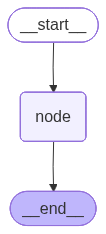

In [ ]:
compiled_grph

In [ ]:
HITL_res = await compiled_grph.ainvoke(HITL_test_state, config=HITL_config)

In [ ]:
HITL_res

{'messages': [HumanMessage(content='Plan a trip to Paris', additional_kwargs={}, response_metadata={}, id='43653120-eb63-4a91-98d7-9df7b2625eeb'),
  AIMessage(content="I'll help you plan your trip to Paris", additional_kwargs={}, response_metadata={}, id='a5aac559-a666-474c-a155-055daa82cab4')],
 'lodging': LodgingAgentOutput(lodging=[CandidateLodging(id=None, name='Hotel Le Marais', address='123 Rue de Rivoli, Paris', price_level='$$', rating=4.5, reviews=None, photos=None, url=None, lat=None, lon=None, evidence_score=0.0, source_id=None, notes=None, area='Le Marais', price_night=160.0, cancel_policy='Free cancellation up to 24 hours')]),
 'intercity_transport': IntercityTransportAgentOutput(transport=[CandidateIntercityTransport(name='Flight NYC-Paris', fare_class='Economy', refundable=False, url=None, price=450.0, transfer=[Transfer(name='Direct Flight', place='JFK to CDG', departure_time='21:00', arrival_time='10:00', duration_min=420)], total_duration_min=420, note=None)]),
 '__in

In [ ]:
interrupt_obj_HITL = HITL_res['__interrupt__'][0].value

transport_interrupt = interrupt_obj_HITL['selections'][1]
lodging_interrupt = interrupt_obj_HITL['selections'][0]

resume_data_HITL = {}

for intr in [transport_interrupt, lodging_interrupt]:
  options = intr.get('options')
  task = intr.get('task')
  _type = intr.get('type')

  for idx, option in enumerate(options):
    print(f"{idx}: {option}\n")

  inpt = int(input(f"{task}: "))
  resume_data_HITL[_type] = options[inpt]

0: {'name': 'Flight NYC-Paris', 'fare_class': 'Economy', 'refundable': False, 'url': None, 'price': 450.0, 'transfer': [{'name': 'Direct Flight', 'place': 'JFK to CDG', 'departure_time': '21:00', 'arrival_time': '10:00', 'duration_min': 420}], 'total_duration_min': 420, 'note': None}

Choose intercity_transport option: 0
0: {'id': None, 'name': 'Hotel Le Marais', 'address': '123 Rue de Rivoli, Paris', 'price_level': '$$', 'rating': 4.5, 'reviews': None, 'photos': None, 'url': None, 'lat': None, 'lon': None, 'evidence_score': 0.0, 'source_id': None, 'notes': None, 'area': 'Le Marais', 'price_night': 160.0, 'cancel_policy': 'Free cancellation up to 24 hours'}

Choose lodging option: 0


In [ ]:
resumed_res = await compiled_grph.ainvoke(
    Command(resume=resume_data_HITL),
    config=HITL_config
)

#Creating graph

In [ ]:
graph_builder = StateGraph(state_schema=State, context_schema=Context)

# Adding nodes
graph_builder.add_node(budget_estimate, name="budget_estimate")
graph_builder.add_node(research_plan, name="research_plan")
graph_builder.add_node(research_lodging, name="research_lodging")
graph_builder.add_node(research_activities, name="research_activities")
graph_builder.add_node(research_food, name="research_food")
graph_builder.add_node(research_intercity_transport, name="research_intercity_transport")
graph_builder.add_node(research_recommendations, name="research_recommendations")
graph_builder.add_node(combined_human_review, name='combined_human_review')
graph_builder.add_node(planner, name="planner")

# Initial flow
graph_builder.add_edge(START, "budget_estimate")
graph_builder.add_edge("budget_estimate", "research_plan")

# Parallel research
graph_builder.add_edge("research_plan", "research_activities")
graph_builder.add_edge("research_plan", "research_lodging")
graph_builder.add_edge("research_plan", "research_food")
graph_builder.add_edge("research_plan", "research_intercity_transport")
graph_builder.add_edge("research_plan", "research_recommendations")

graph_builder.add_edge("research_activities", "combined_human_review")
graph_builder.add_edge("research_lodging", "combined_human_review")
graph_builder.add_edge("research_food", "combined_human_review")
graph_builder.add_edge("research_intercity_transport", "combined_human_review")
graph_builder.add_edge("research_recommendations", "combined_human_review")

# Then from combined_human_review to planner
graph_builder.add_edge("combined_human_review", "planner")

graph_builder.add_conditional_edges("planner",
                                    path=route_from_planner)

# IMPORTANT: Add interrupt_before
memory = InMemorySaver()
research_graph = graph_builder.compile(
    checkpointer=memory
)

In [ ]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [ ]:
thread_id = f"trip_{uuid.uuid4()}"

In [ ]:
config = {
    "recursion_limit": 100,
    "configurable":{"thread_id": thread_id}
}

initial_state = State(messages=[], estimated_budget=None, research_plan=None)

In [ ]:
res = []

In [ ]:
research_res = await research_graph.ainvoke(state, config=config, context=context)

In [ ]:
interrupt_obj = research_res['__interrupt__'][0].value

transport_interrupt = interrupt_obj['selections'][1]
lodging_interrupt = interrupt_obj['selections'][0]

resume_data = {}

for interrupt in [transport_interrupt, lodging_interrupt]:
  options = interrupt.get('options')
  task = interrupt.get('task')
  _type = interrupt.get('type')

  for idx, option in enumerate(options):
    print(f"{idx}: {option}\n")

  inpt = int(input(f"{task}: "))
  resume_data[_type] = options[inpt]

IndexError: list index out of range

In [ ]:
resume_data

In [ ]:
resumed_res = await research_graph.ainvoke(Command(resume=resume_data), config=config)

In [ ]:
resumed_res

In [ ]:
for day in resumed_res['final_plan'].days:
  print(f'Day number {day.day_number} ({day.day_date}\nActivities: {day.activities}\nFood:{day.food})')

In [ ]:
res_list = []
async for rg in research_graph.aget_state_history(config=config):
    res_list.append(rg)

In [ ]:
res_list[-1]

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': 'trip_ec816763-6ac0-4257-948c-e33199898e1e', 'checkpoint_ns': '', 'checkpoint_id': '1f098af0-facb-64dd-bfff-5d798f98bf36'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-09-23T18:56:49.816070+00:00', parent_config=None, tasks=(PregelTask(id='d856fec9-ada0-2de7-3aa7-bd22bfa41b25', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'messages': []}),), interrupts=())